In [1]:
import gym
from collections import deque
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

seed = 0
np.random.seed(seed)

# Helper Function for Visualization

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# REINFORCE Agent

### We use policy gradient $\nabla \log(\pi(a_t|a_t)) Q(s_t, a_t)$

### State action value is estimated by MC sampling $G_t = \sum_{k=0}^{T} \gamma^{k} R_{t+1+k}$

### After training, in evaluation step,

### We control agent with maximum probability $\max_{a} \pi(a|s)$ (Heuristic)

In [3]:
class REINFORCEAgent(object):
    def __init__(self, obs_dim, n_act,
                 epochs=10, lr=3e-5, hdim=64, max_std=1.0,
                 seed=0):
        
        self.seed=0
        
        self.obs_dim = obs_dim
        self.n_act = n_act
        
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.max_std = max_std
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.int32, (None, ), 'act')
        self.score_ph = tf.placeholder(tf.float32, (None,), 'score')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        
    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        # TWO HIDDEN LAYERS
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
        self.logits = tf.layers.dense(out, self.n_act, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="logits")
        
        # SOFTMAX POLICY
        self.pi = tf.nn.softmax(self.logits)
        
        # SAMPLE OPERATION
        categorical = tf.distributions.Categorical(logits=self.logits)
        self.sample_action = categorical.sample(1)
        
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER        
        one_hot_act = tf.one_hot(self.act_ph,self.n_act)
        self.log_p = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_act,logits=self.logits)
        
    def _loss_train_op(self):
        
        # REINFORCE OBJECTIVE
        self.loss = -tf.reduce_mean(self.score_ph*self.log_p)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)

    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def get_action(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action, = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action[0]
    
    def control(self, obs): # COMPUTE MAX PROB
        feed_dict = {self.obs_ph: obs}
        best_action = np.argmax(self.sess.run(self.pi,feed_dict=feed_dict))
        return best_action        
    
    def update(self, observes, actions, scores, batch_size = 128): # TRAIN POLICY
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        for e in range(self.epochs):
            observes, actions, scores = shuffle(observes, actions, scores, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end],
                     self.score_ph: scores[start:end],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
        feed_dict = {self.obs_ph: observes,
             self.act_ph: actions,
             self.score_ph: scores,
             self.lr_ph: self.lr}               
        loss  = self.sess.run(self.loss, feed_dict)
        return loss
    
    def close_sess(self):
        self.sess.close()

# Helper Function for Training

In [4]:
def run_episode(env, agent): # Run policy and collect (state, action, reward) pairs
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        action = agent.get_action([obs])
        
        next_obs, reward, done, info = env.step(action)
        
        observes.append(obs)
        actions.append(action)
        rewards.append(reward)
        infos.append(info)
        
        obs = next_obs
    return np.asarray(observes), np.asarray(actions), np.asarray(rewards), infos

def run_policy(env, agent, episodes): # collect trajectories. if 'evaluation' is ture, then only mean value of policy distribution is used without sampling.
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, agent)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

def build_train_set(trajectories):
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    returns = np.concatenate([t['returns'] for t in trajectories])

    return observes, actions, returns

def compute_returns(trajectories, gamma=0.995): # Add value estimation for each trajectories
    for trajectory in trajectories:
        rewards = trajectory['rewards']
        returns = np.zeros_like(rewards)
        g = 0
        for t in reversed(range(len(rewards))):
            g = rewards[t] + gamma*g
            returns[t] = g
        trajectory['returns'] = returns

# Training

In [5]:
env = gym.make('CartPole-v1')

env.seed(seed=seed)

obs_dim = env.observation_space.shape[0]
n_act = env.action_space.n

agent = REINFORCEAgent(obs_dim, n_act, epochs=5, hdim=32, lr=3e-4,seed=seed)

#
avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)

episode_size = 1
batch_size = 64
nupdates = 1000

for update in range(nupdates+1):

    trajectories = run_policy(env, agent, episodes=episode_size)
    compute_returns(trajectories)
    observes, actions, returns = build_train_set(trajectories)

    pol_loss = agent.update(observes, actions, returns, batch_size=batch_size)
    
    avg_loss_list.append(pol_loss)
    avg_return_list.append([np.sum(t['rewards']) for t in trajectories])
    if (update%200) == 0:
        print('[{}/{}] policy loss : {:.3f}, return : {:.3f}'.format(update, nupdates, np.mean(avg_loss_list), np.mean(avg_return_list)))
        
    if (np.mean(avg_return_list) > 490): # Threshold return to success cartpole
        print('[{}/{}] policy loss : {:.3f}, return : {:.3f}'.format(update,nupdates, np.mean(avg_loss_list), np.mean(avg_return_list)))
        print('The problem is solved with {} episodes'.format(update*episode_size))
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/1000] policy loss : 11.796, return : 35.000
[200/1000] policy loss : 14.002, return : 50.000
[400/1000] policy loss : 45.188, return : 266.500
[600/1000] policy loss : 37.487, return : 242.200
[714/1000] policy loss : 63.679, return : 491.900
The problem is solved with 714 episodes


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 462.00



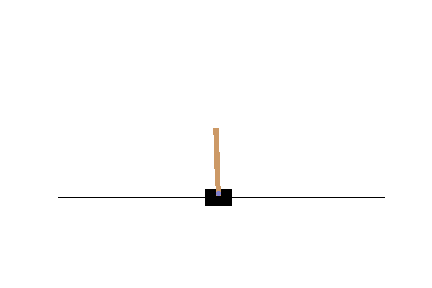
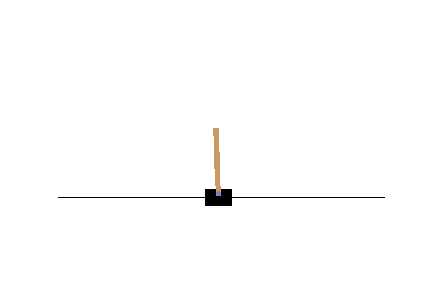
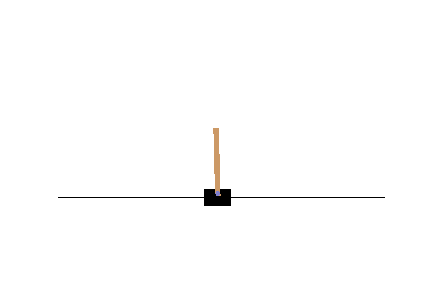
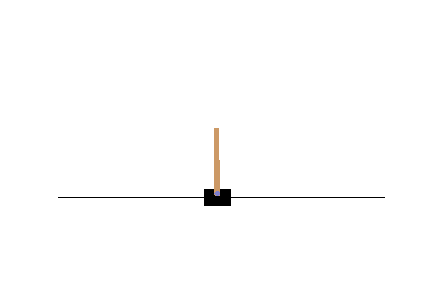
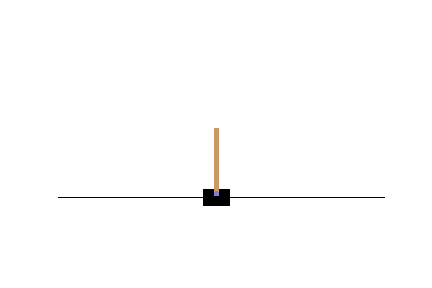
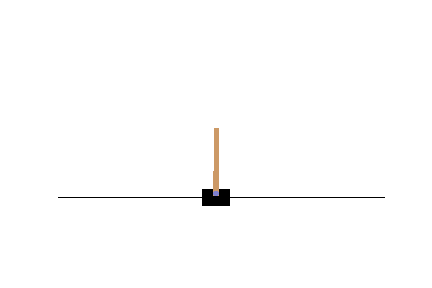
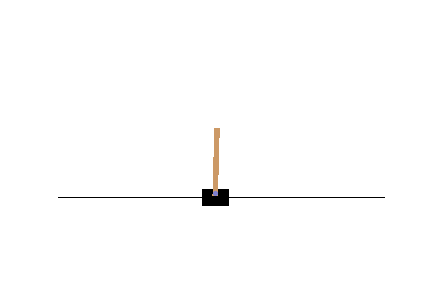
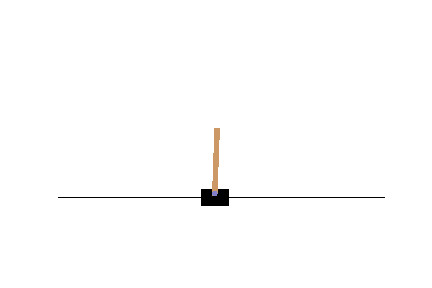
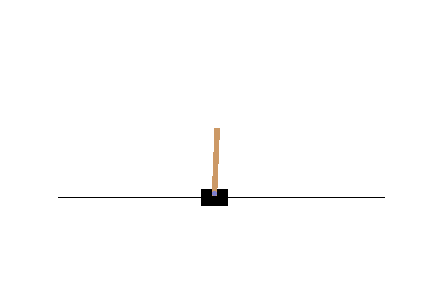
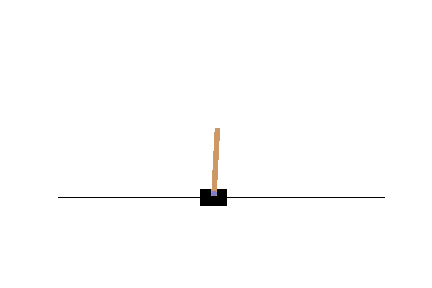
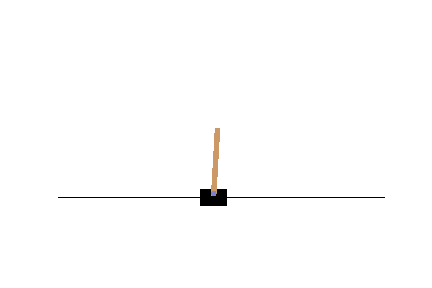
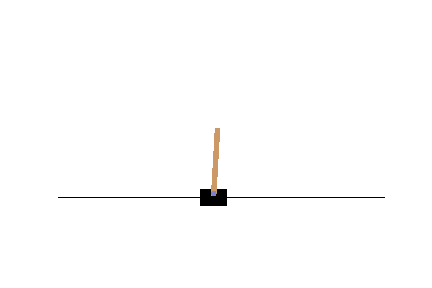
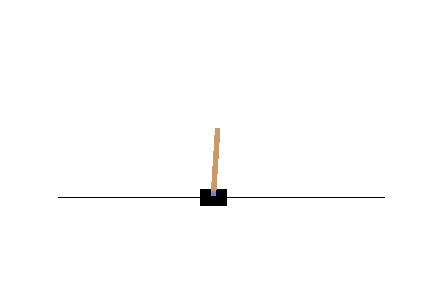
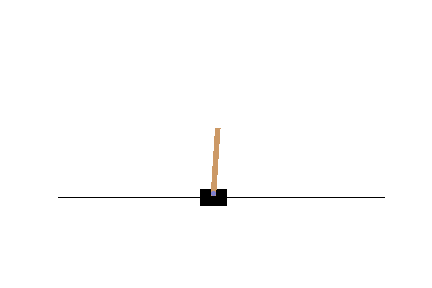
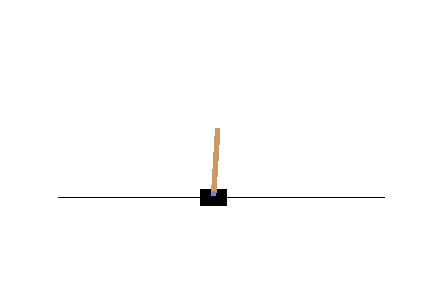
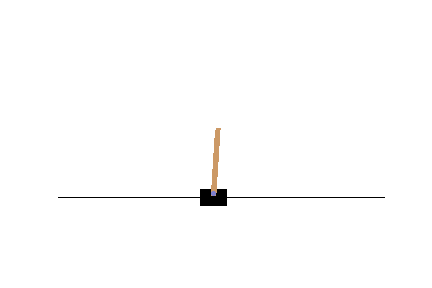
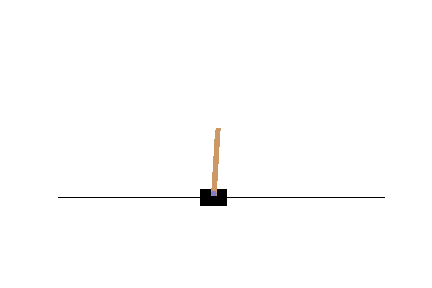
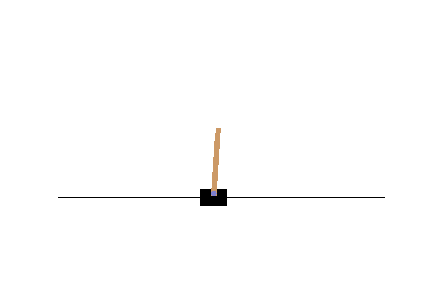
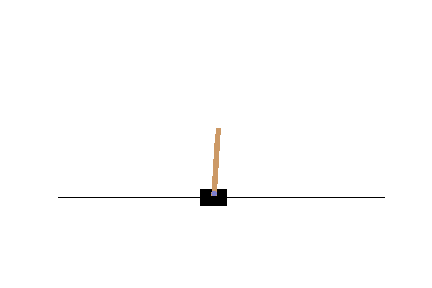
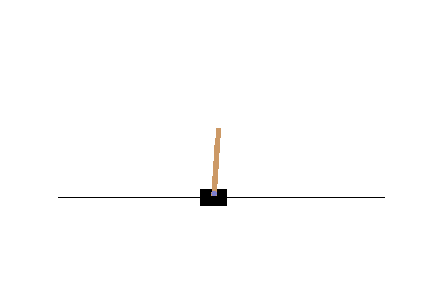
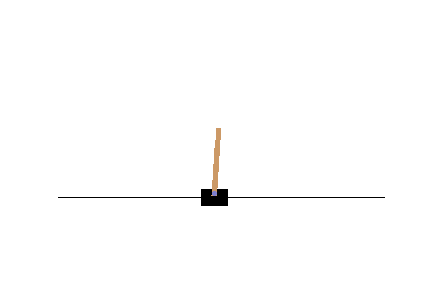
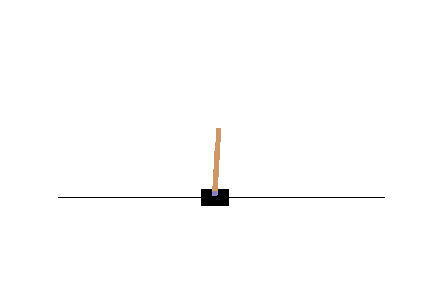
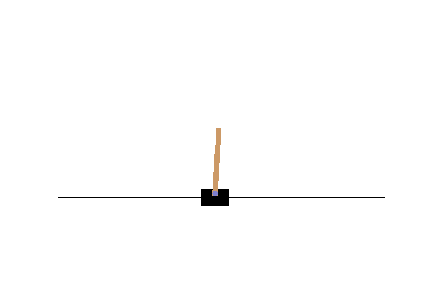
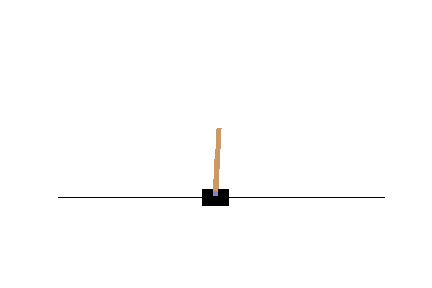
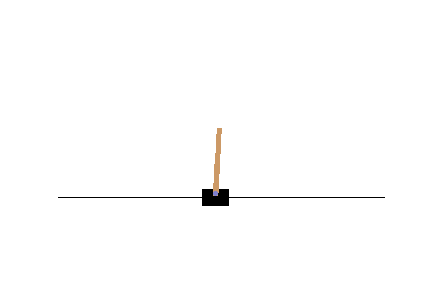
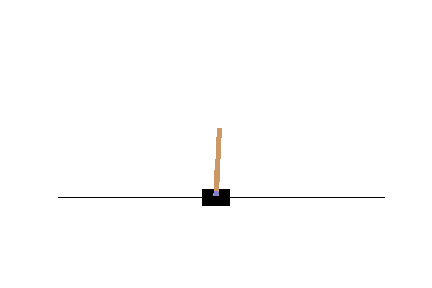
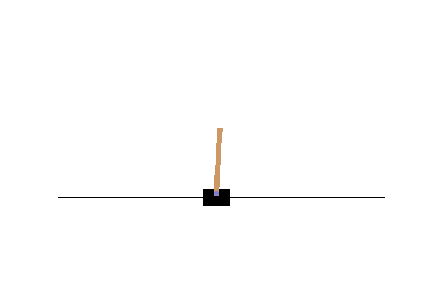
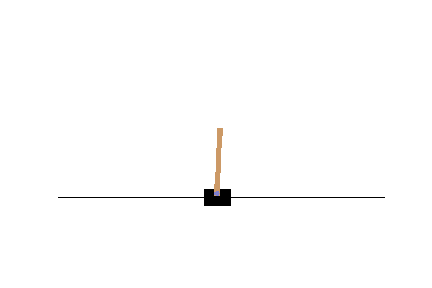
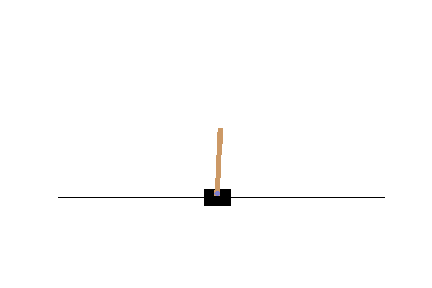
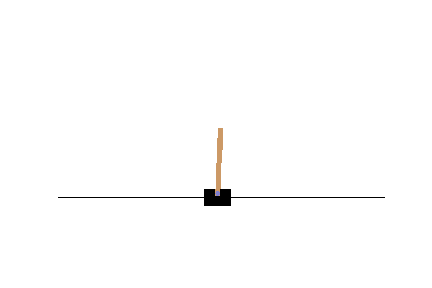
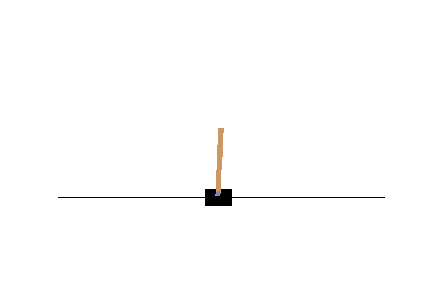
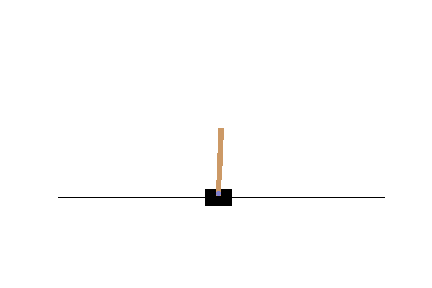
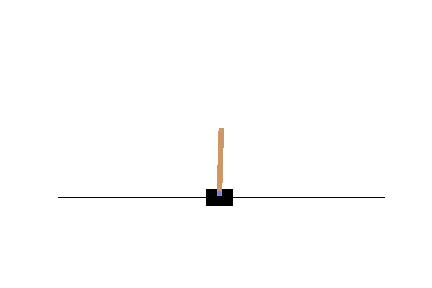
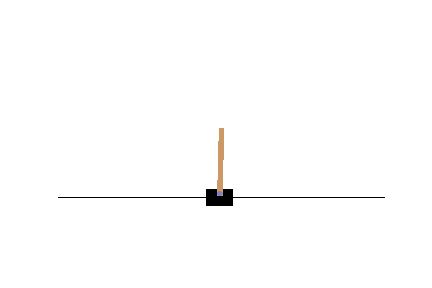
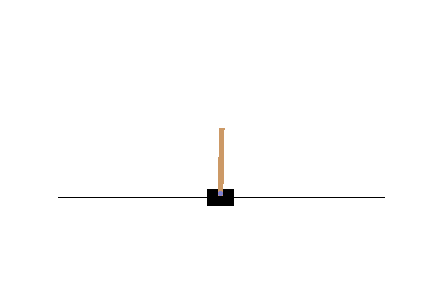
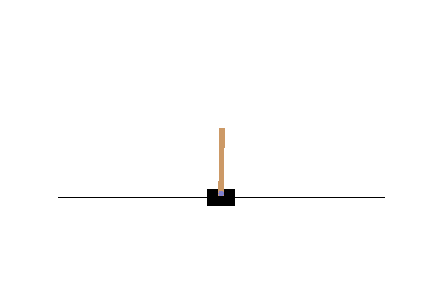
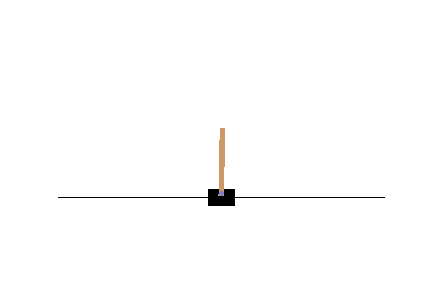
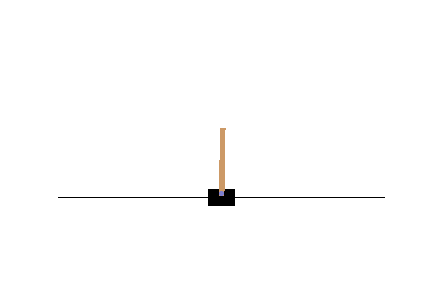
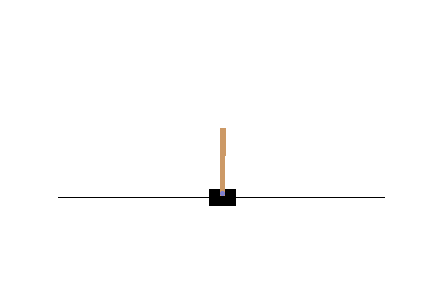
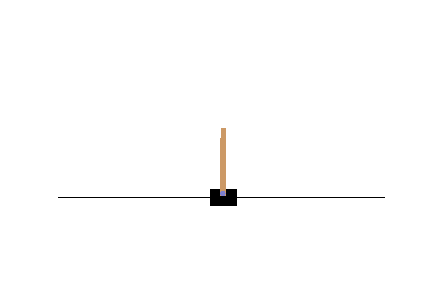
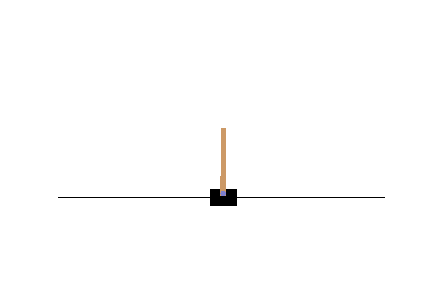
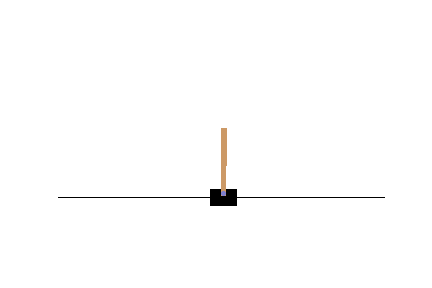
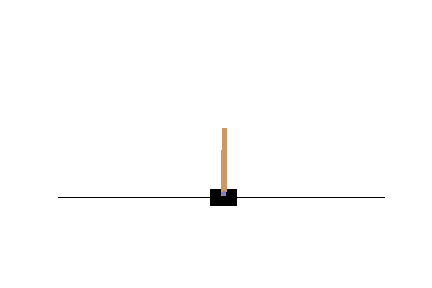
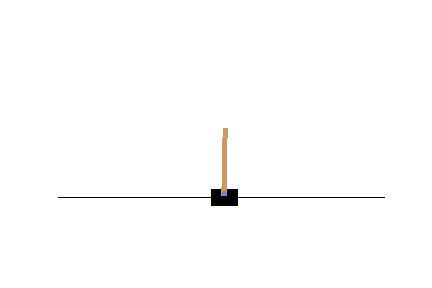
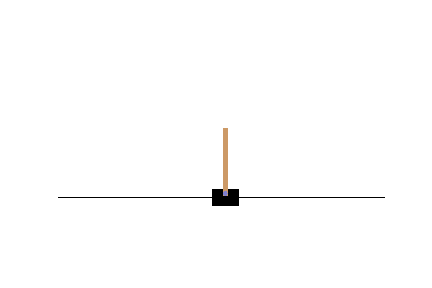
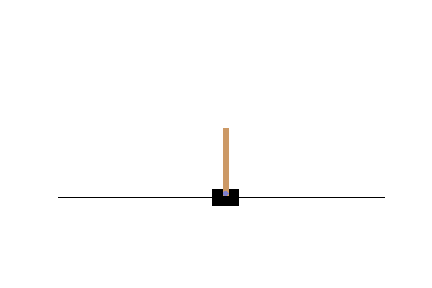
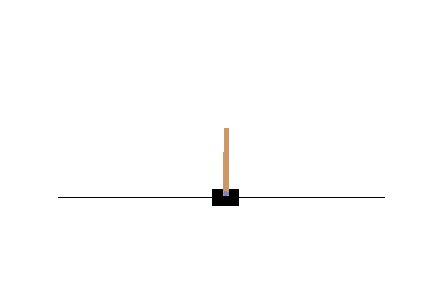
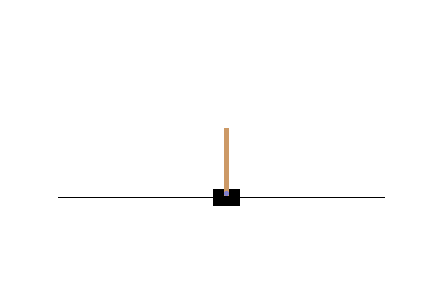
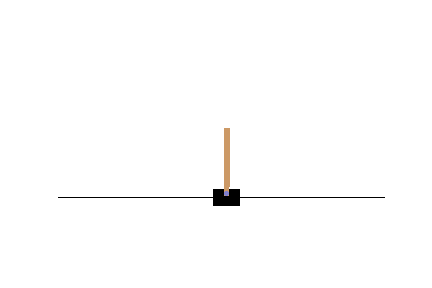
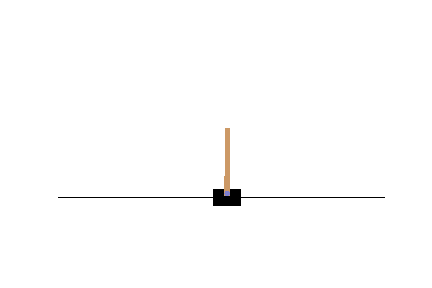
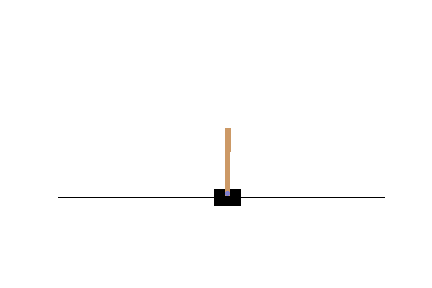
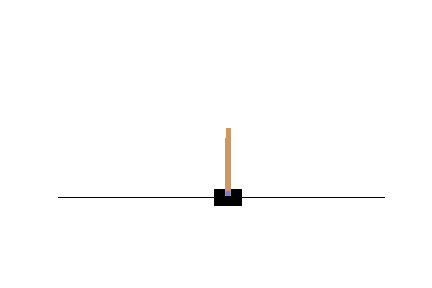
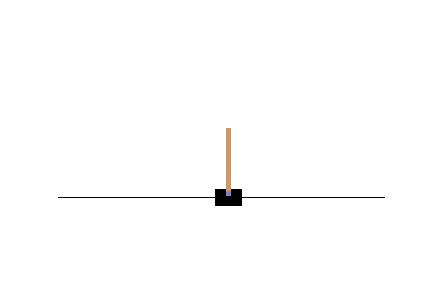
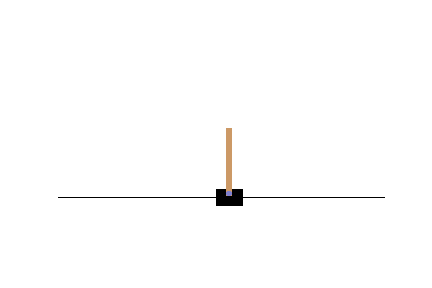
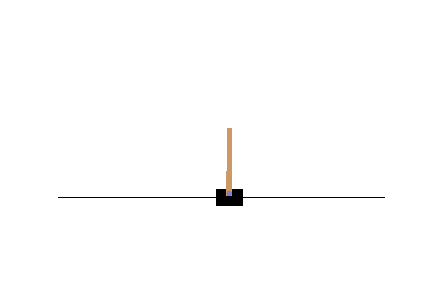
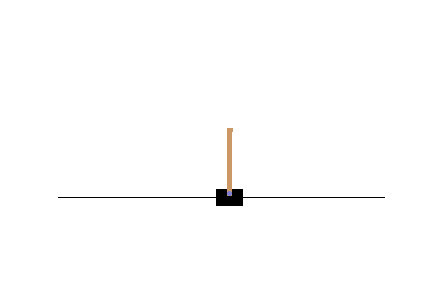
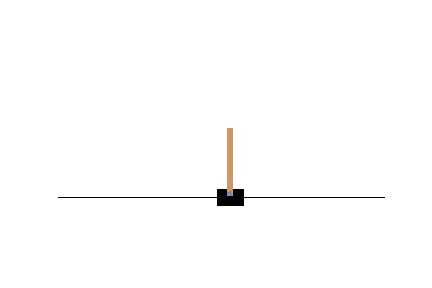
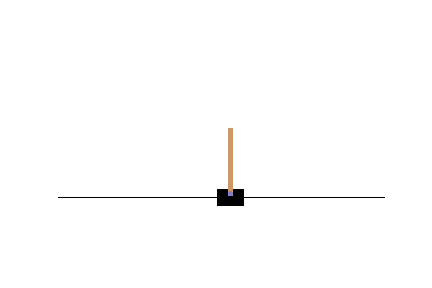
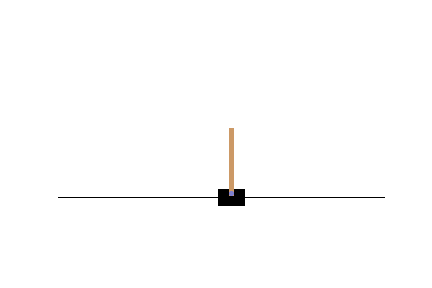
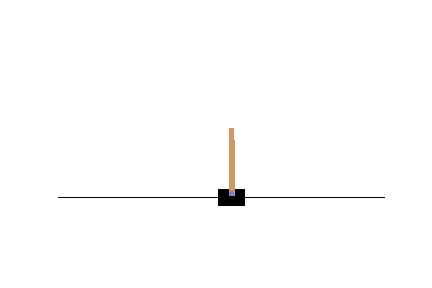
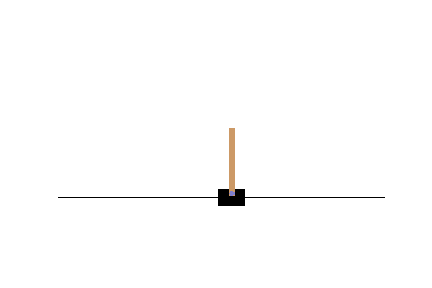
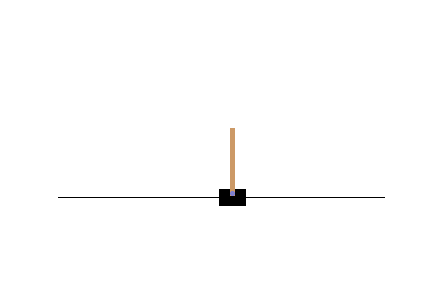
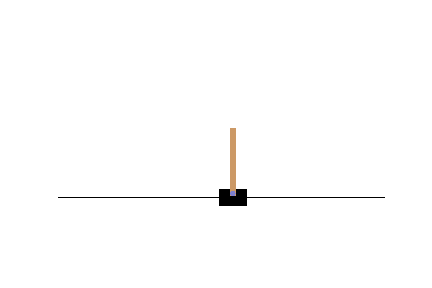
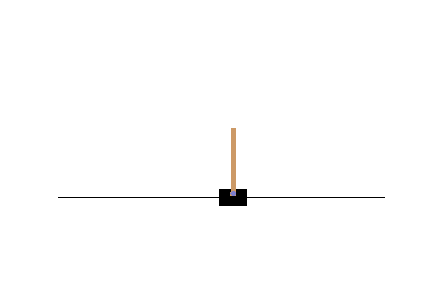
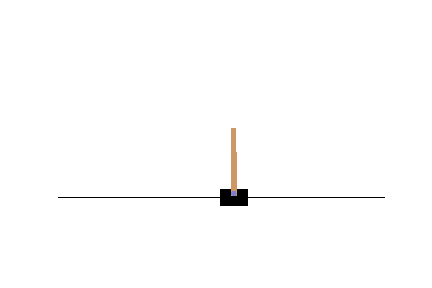
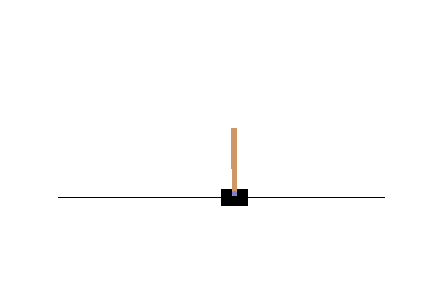
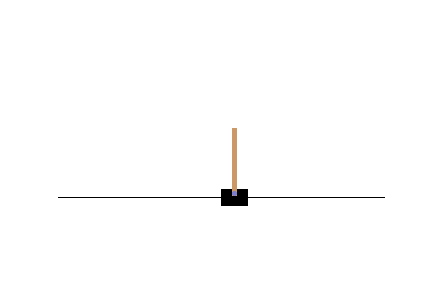
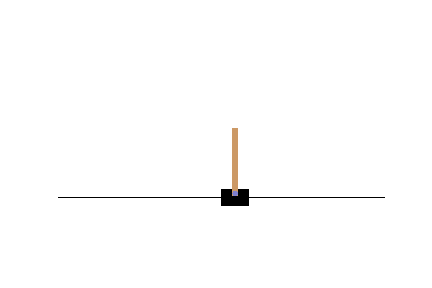
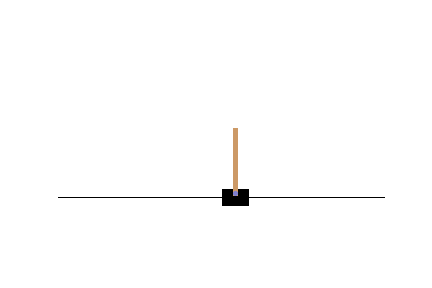
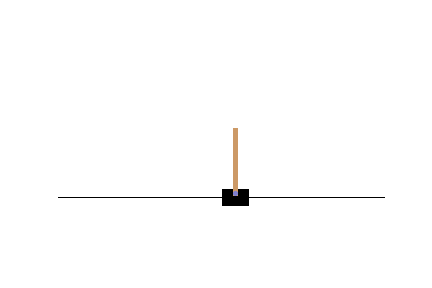
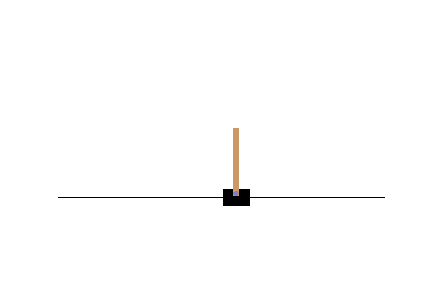
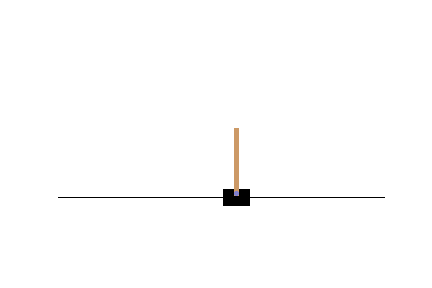
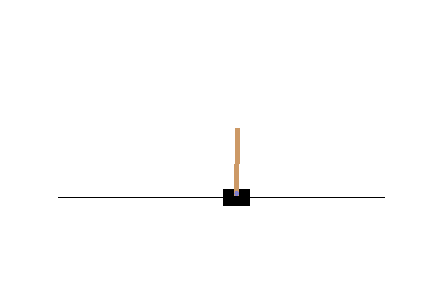
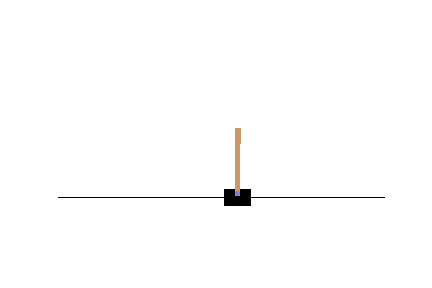
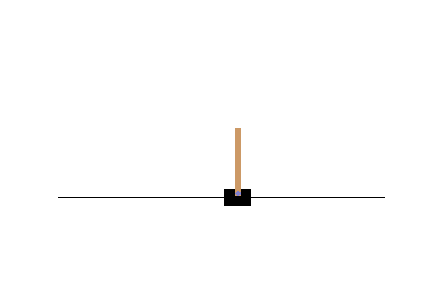
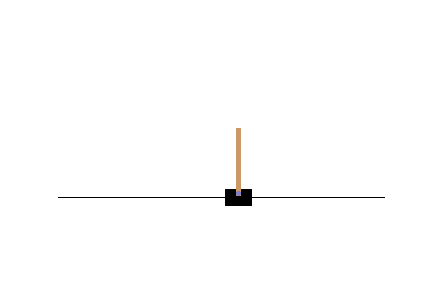
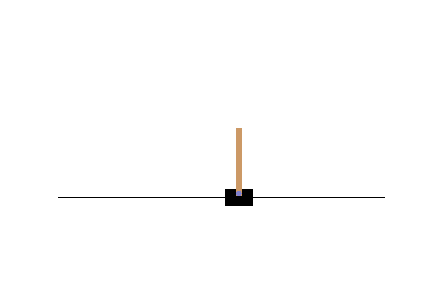
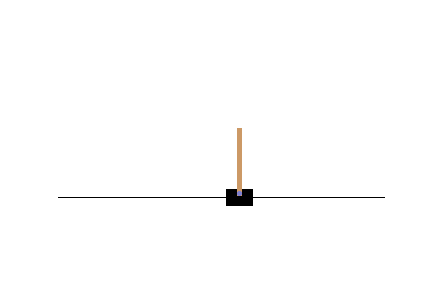
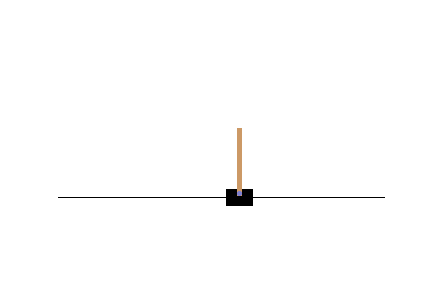
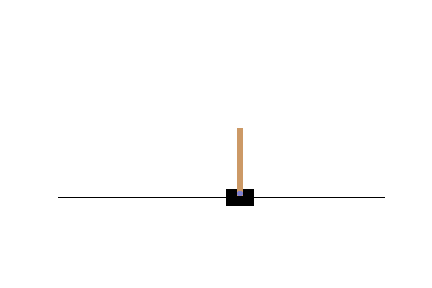
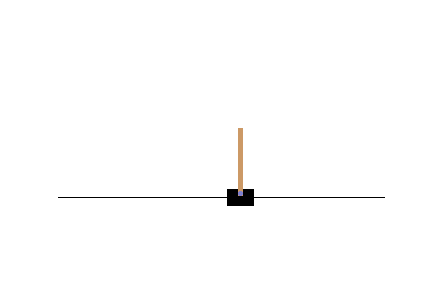
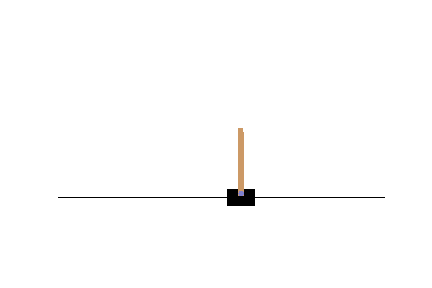
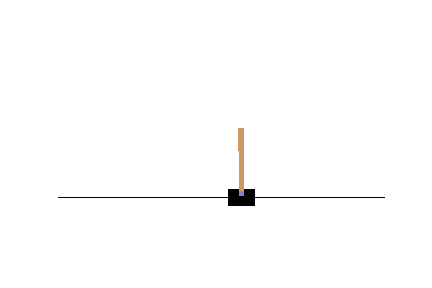
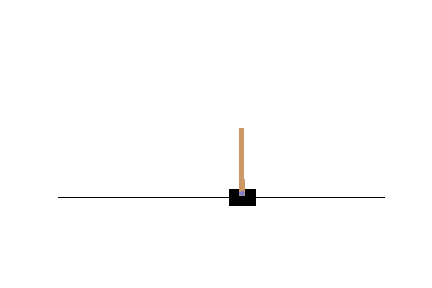
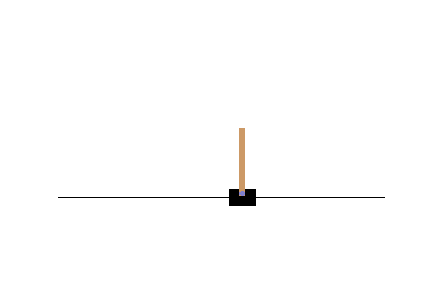
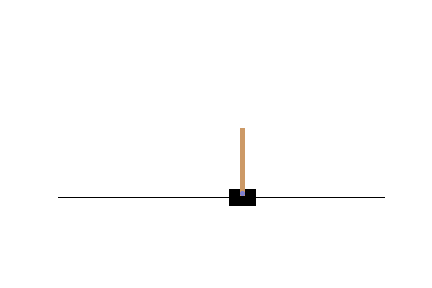
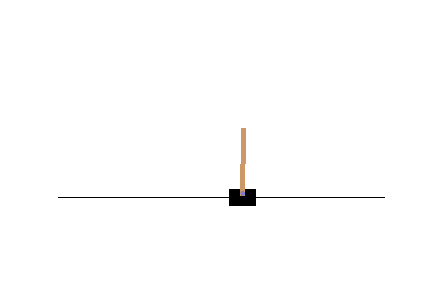
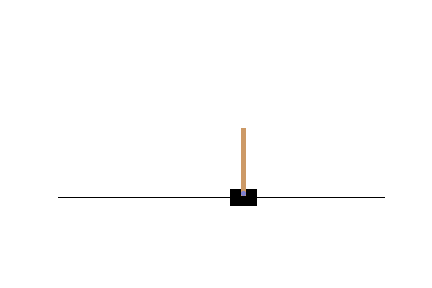
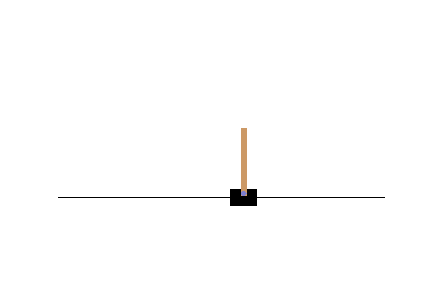
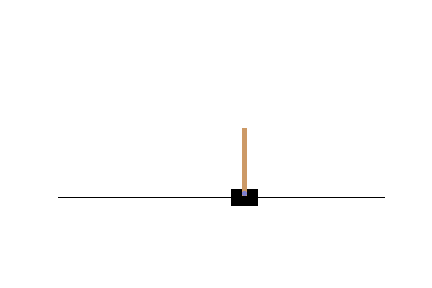
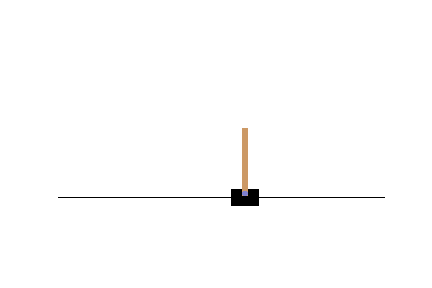
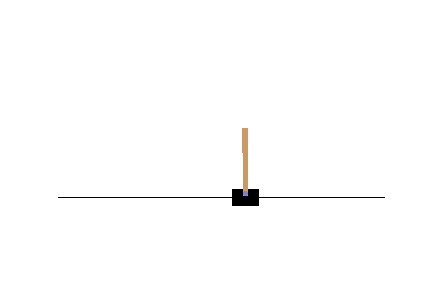
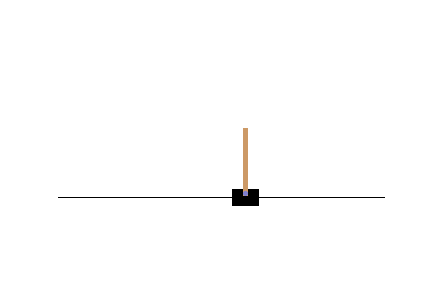
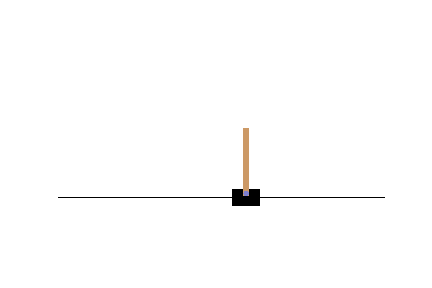
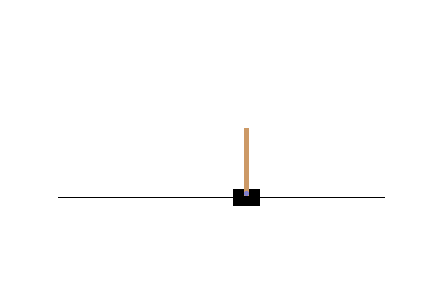
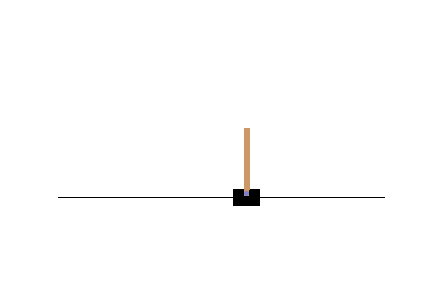
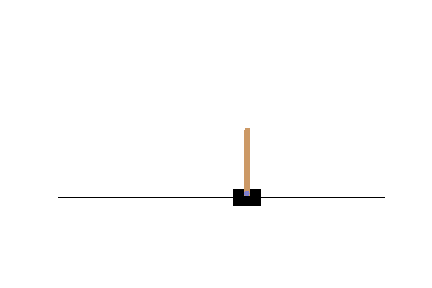
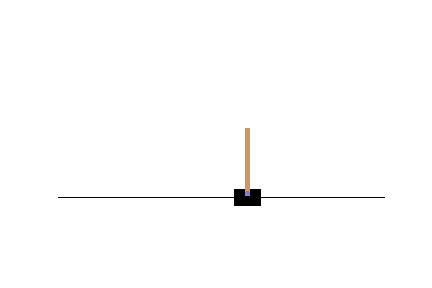
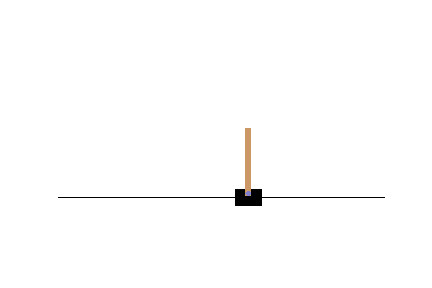
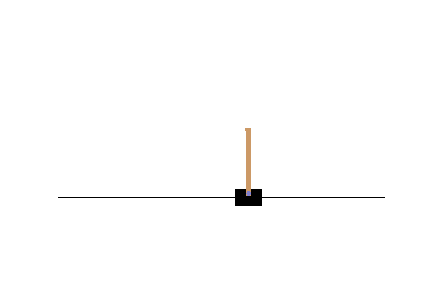
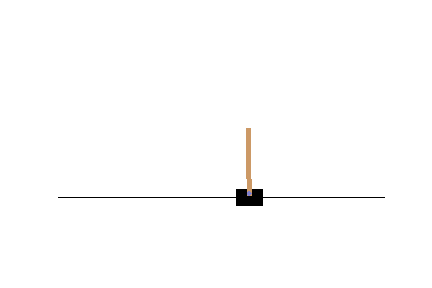
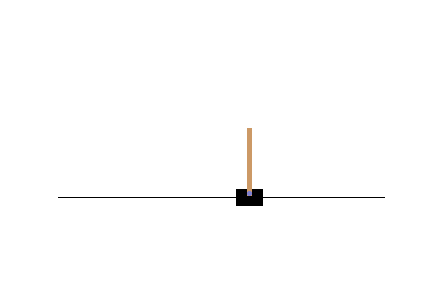
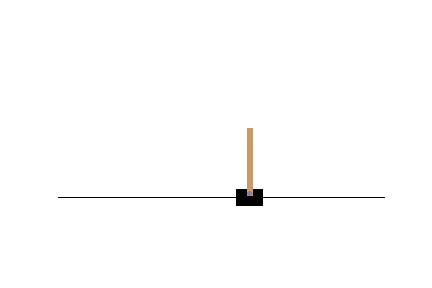
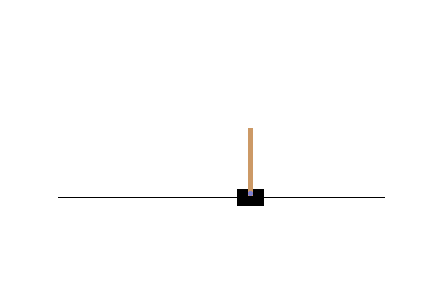
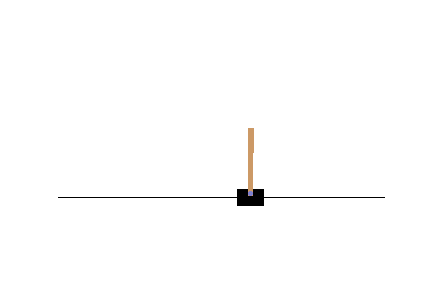
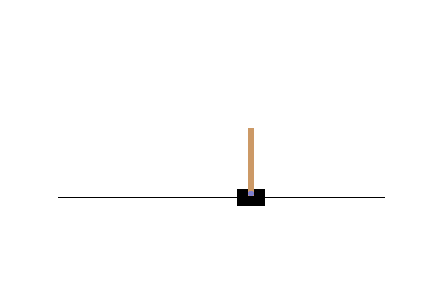
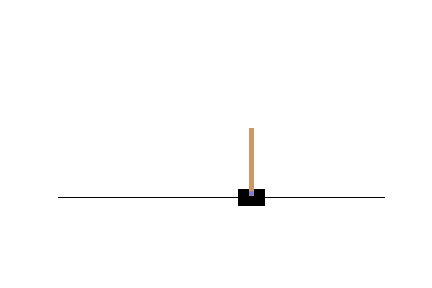
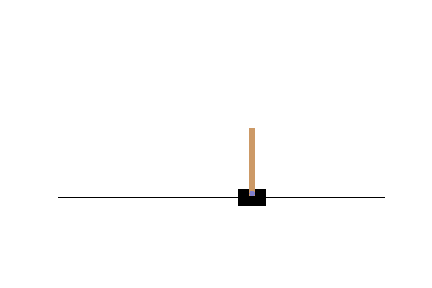
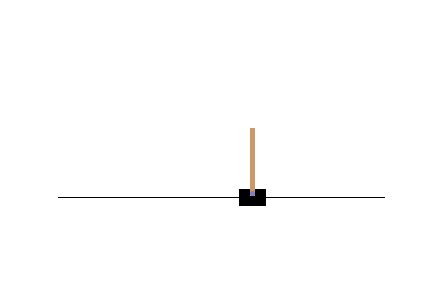
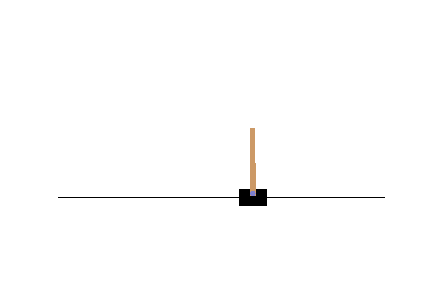
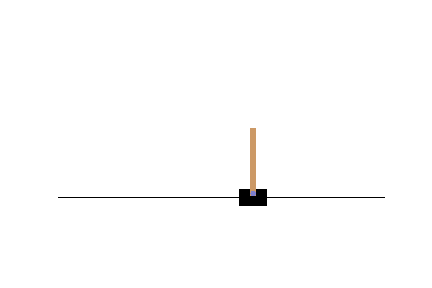
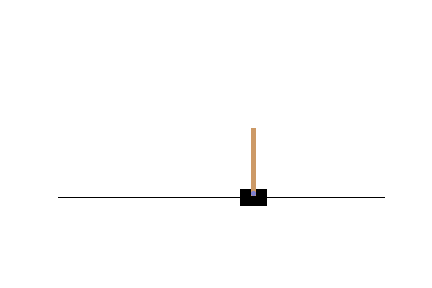
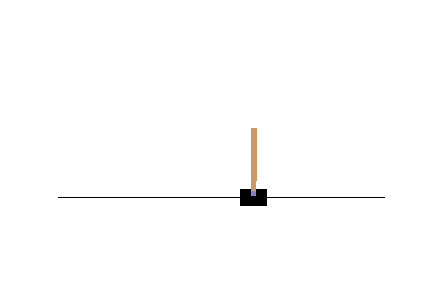
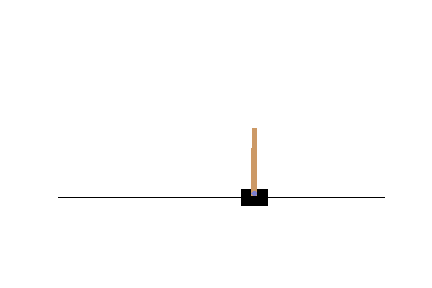
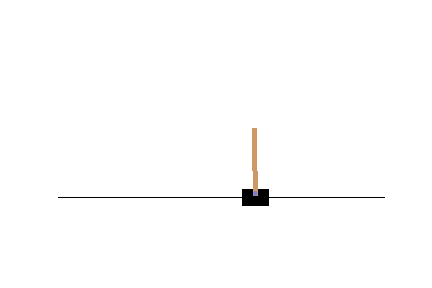
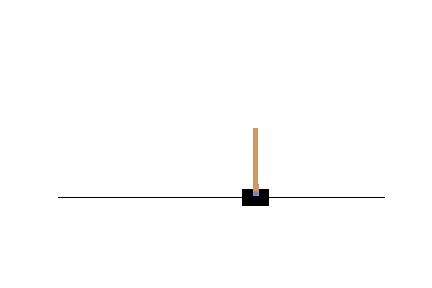
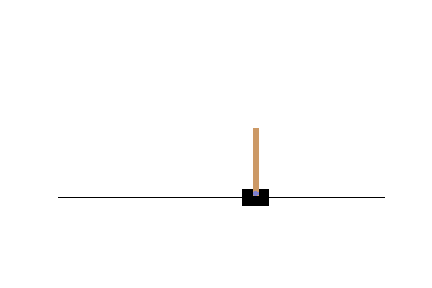
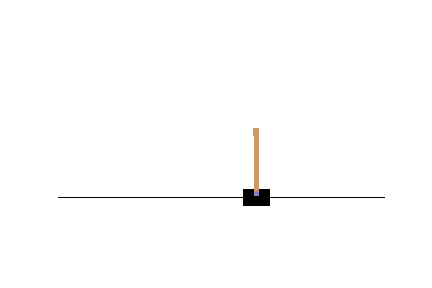
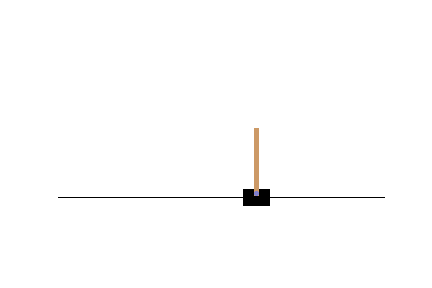
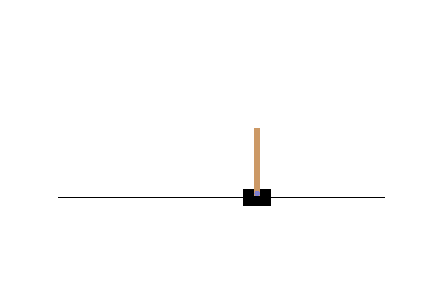
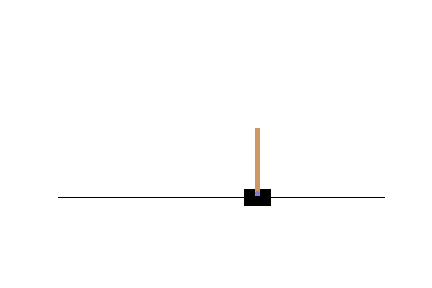
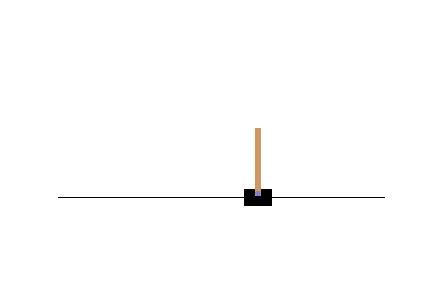
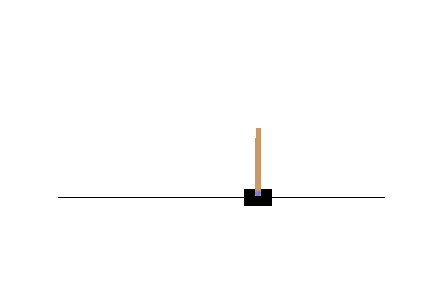
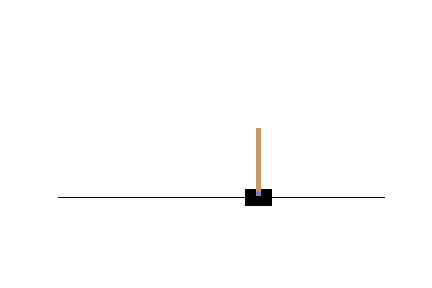
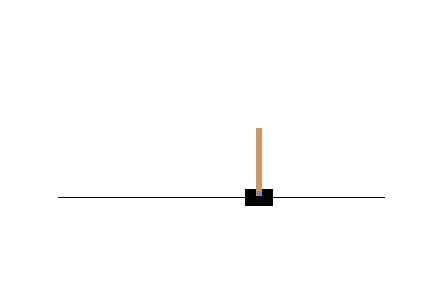
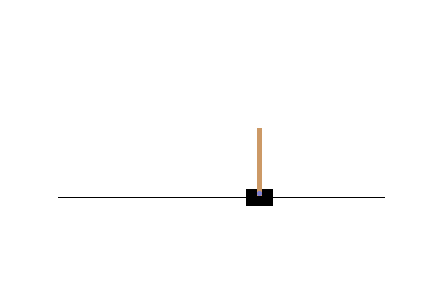
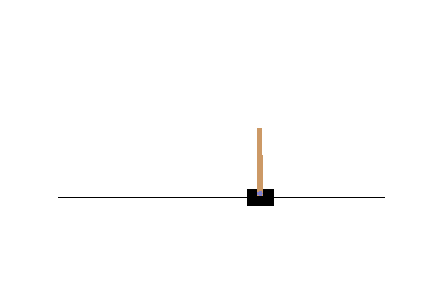
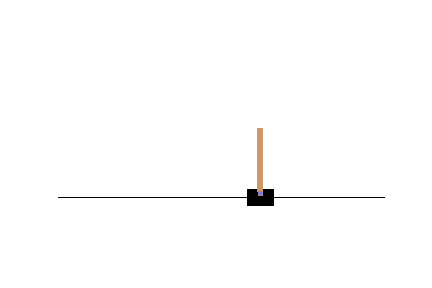
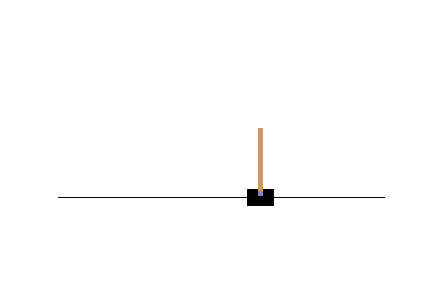
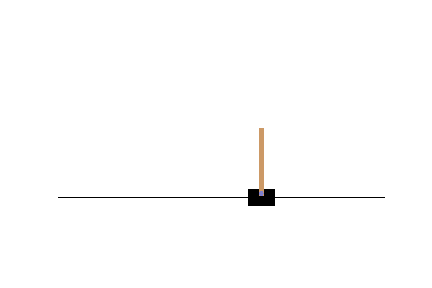
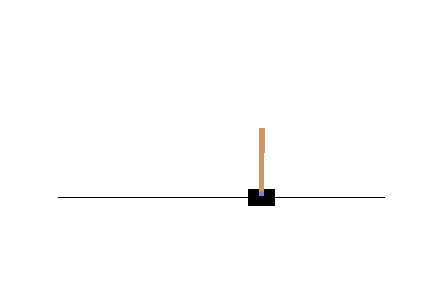
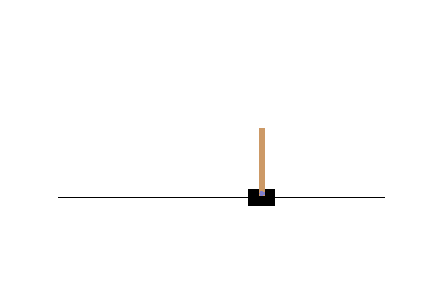
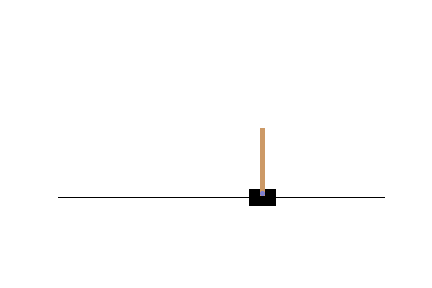
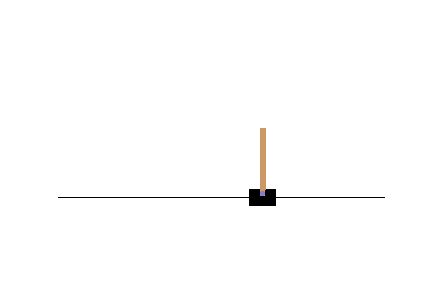
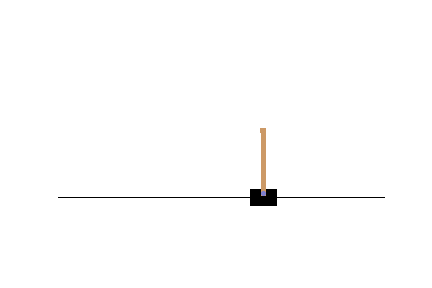
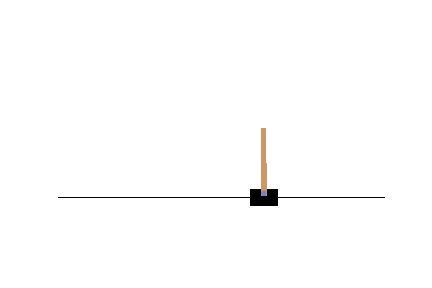
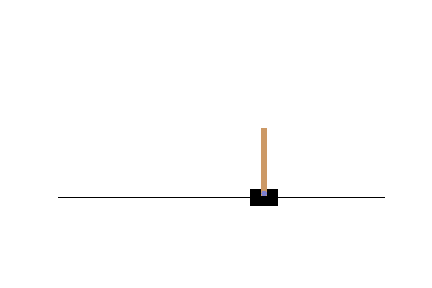
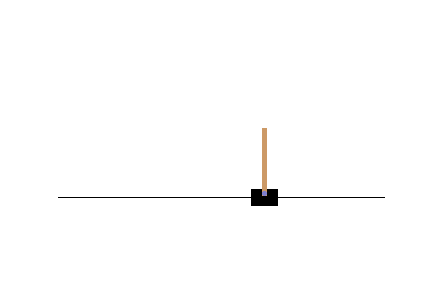
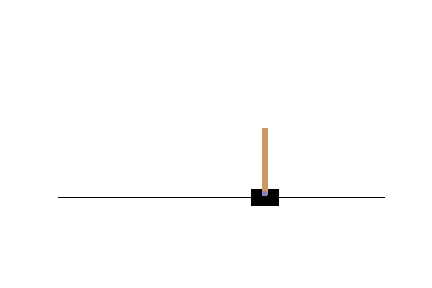
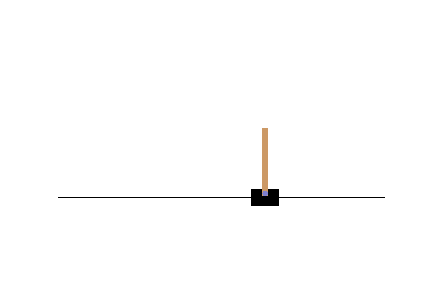
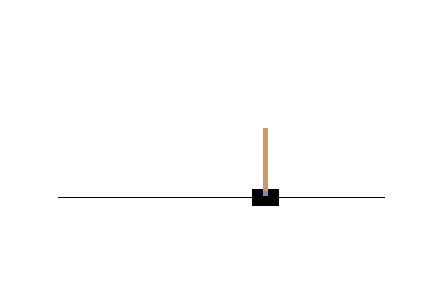
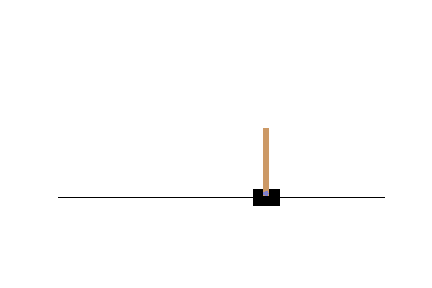
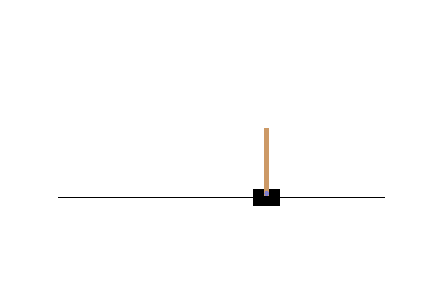
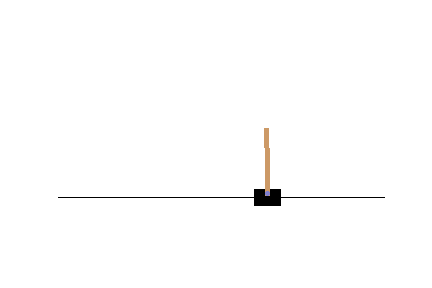
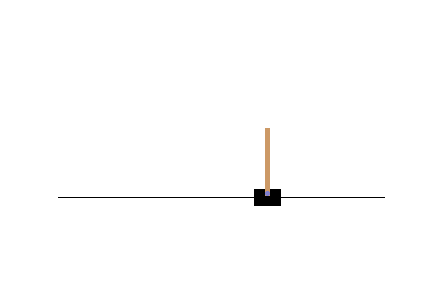
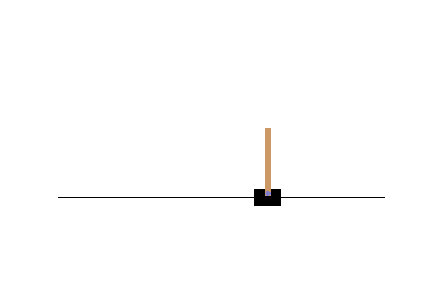
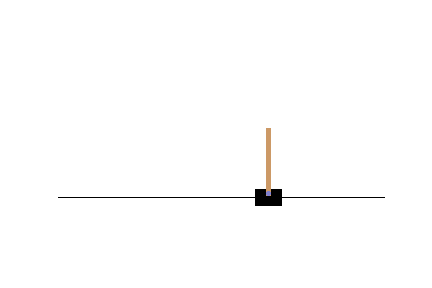
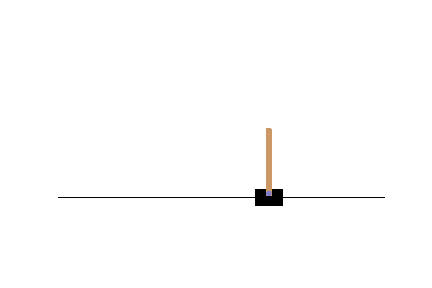
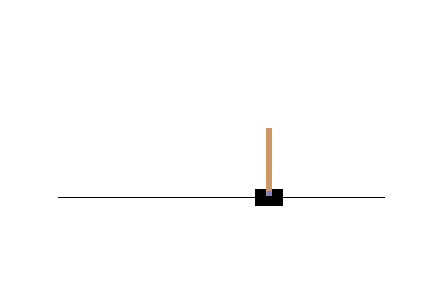
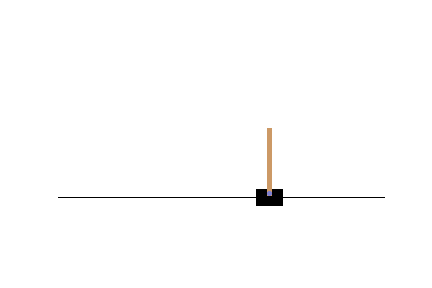
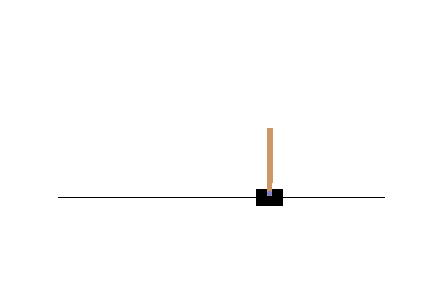
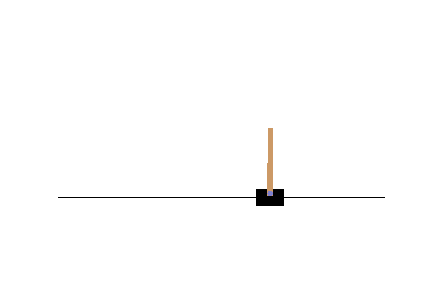
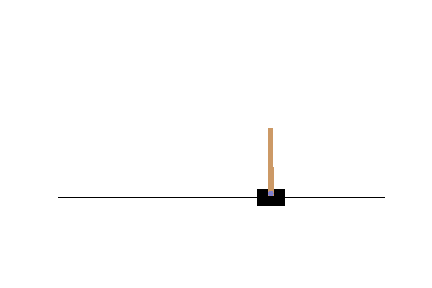
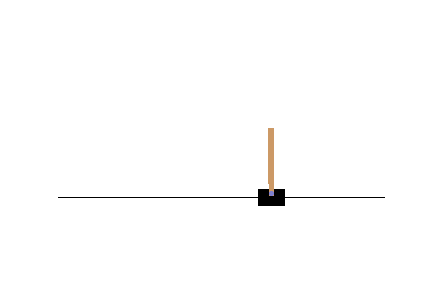
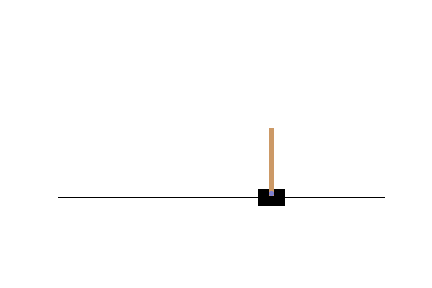
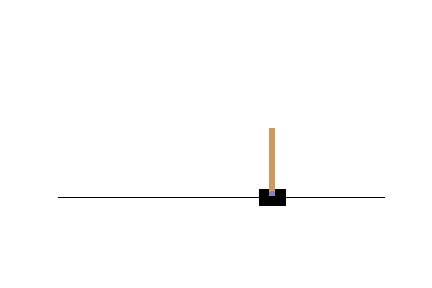
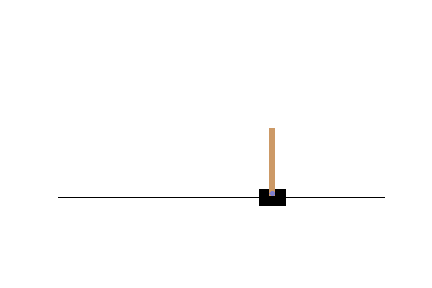
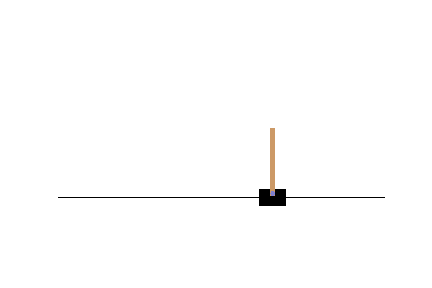
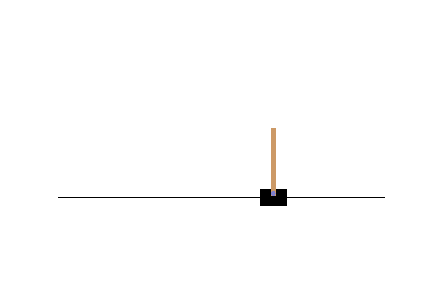
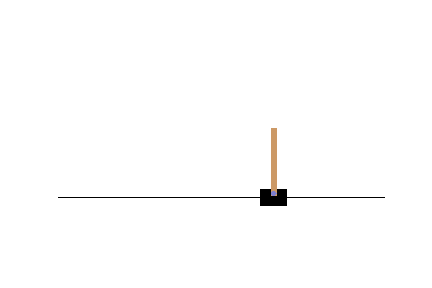
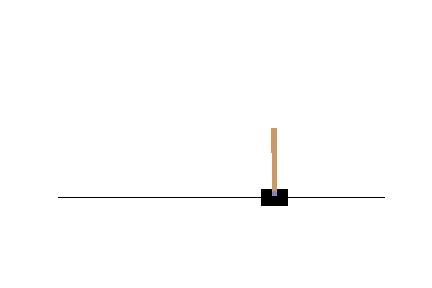
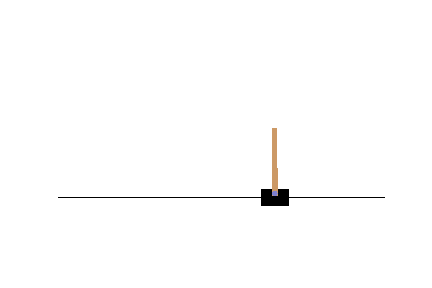
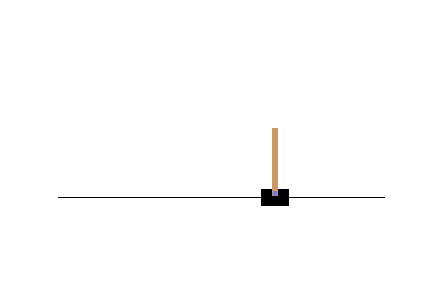
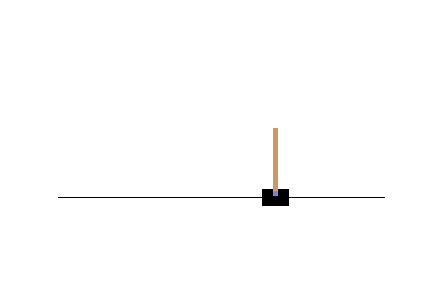
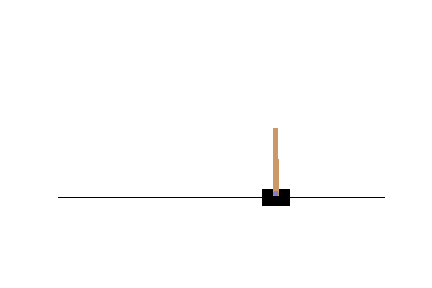
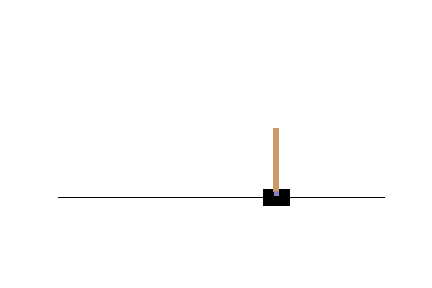
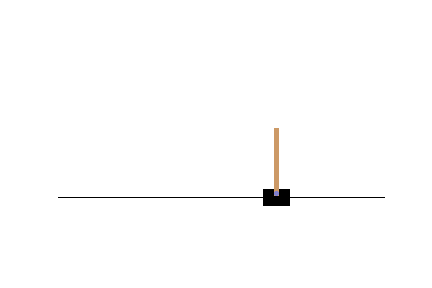
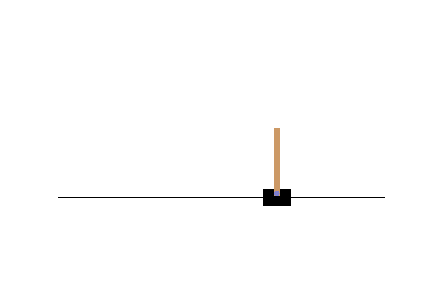
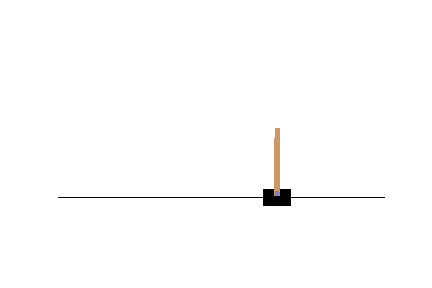
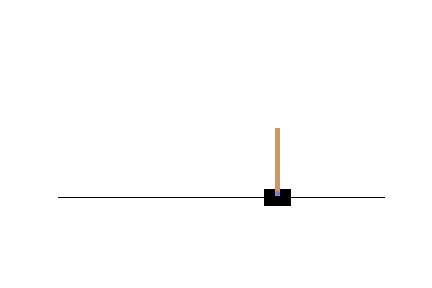
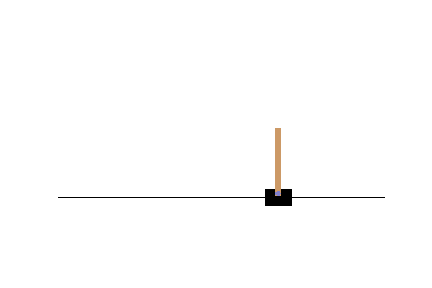
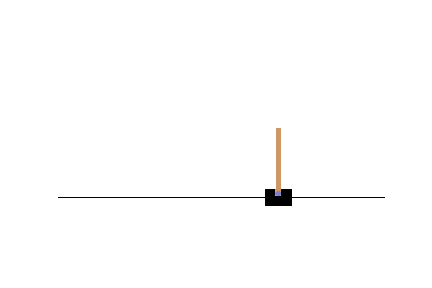
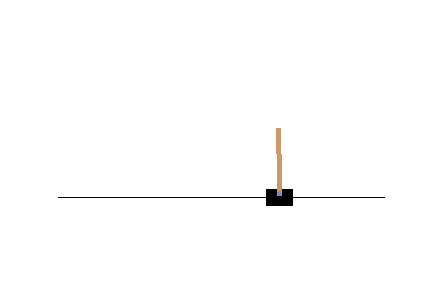
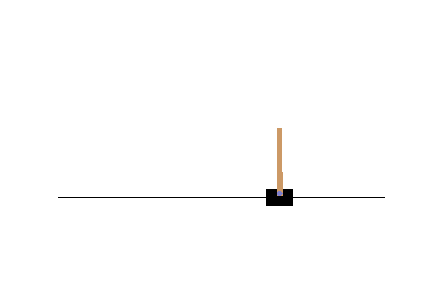
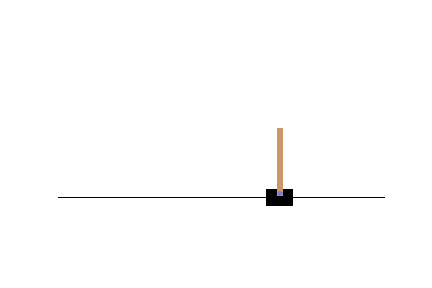
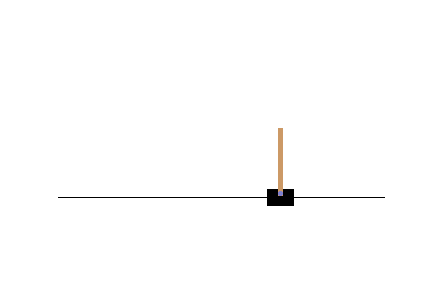
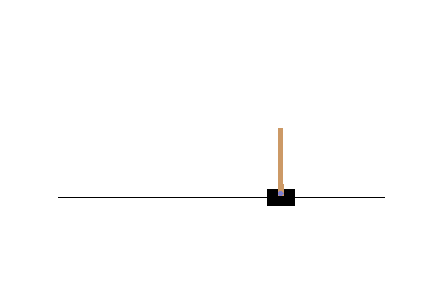
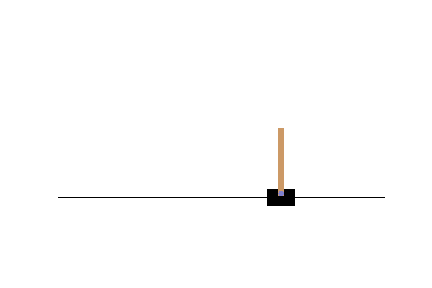
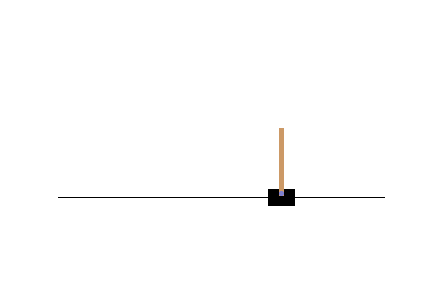
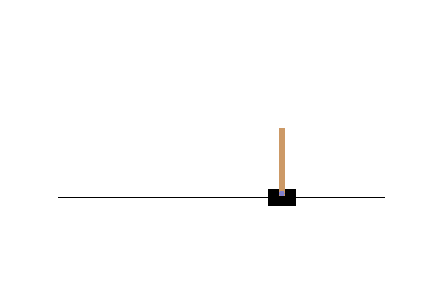
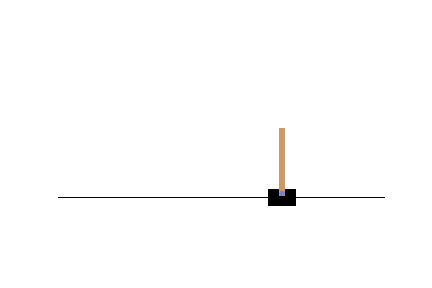
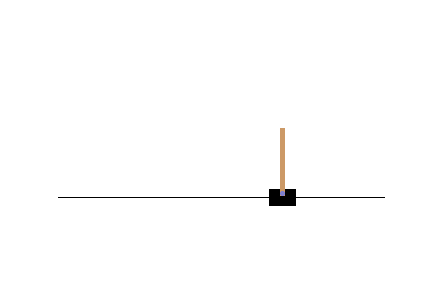
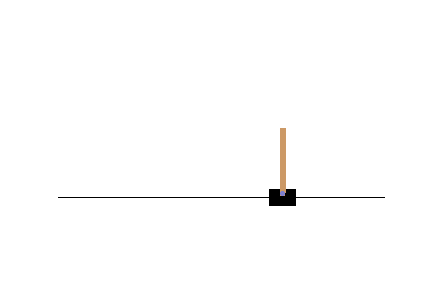
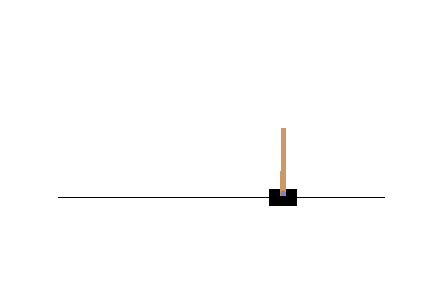
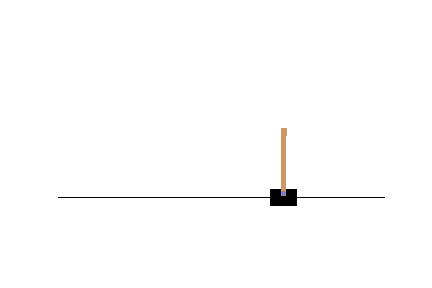
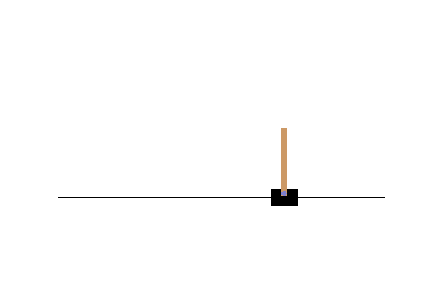
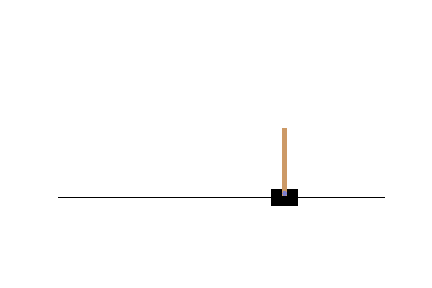
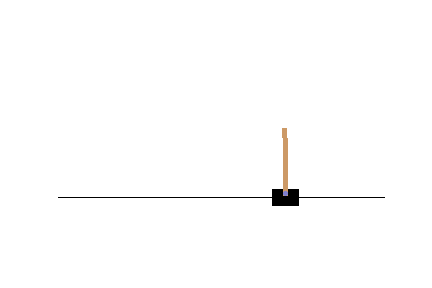
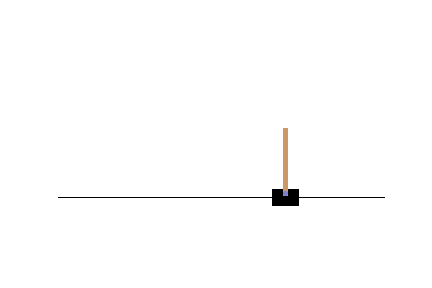
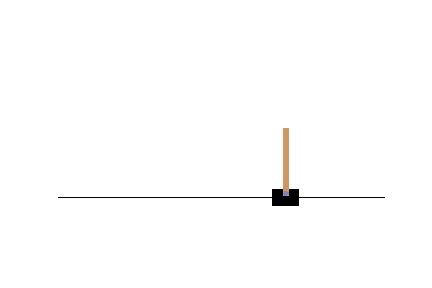
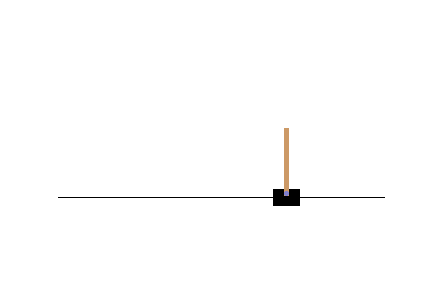
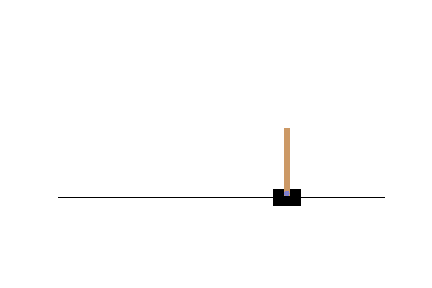
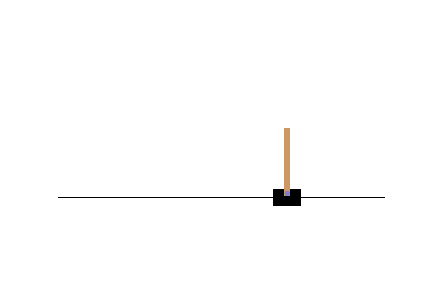
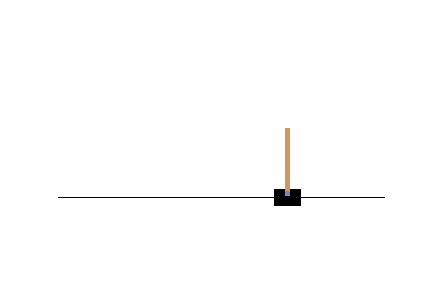
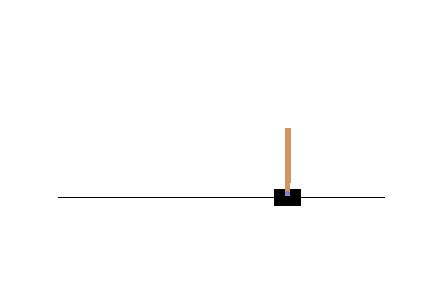
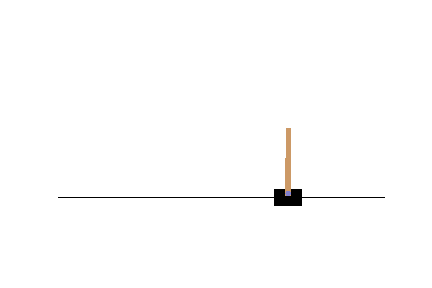
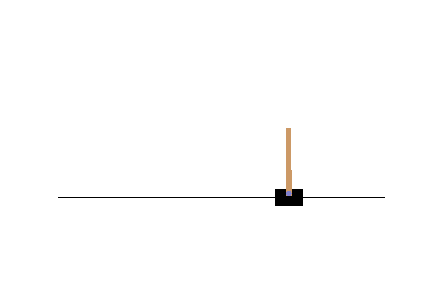
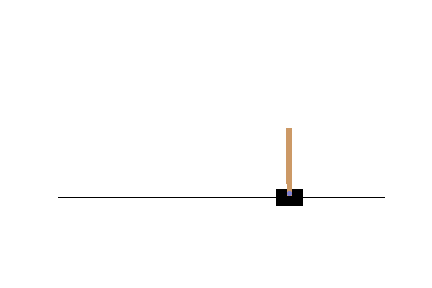
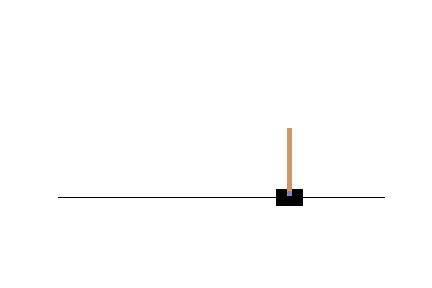
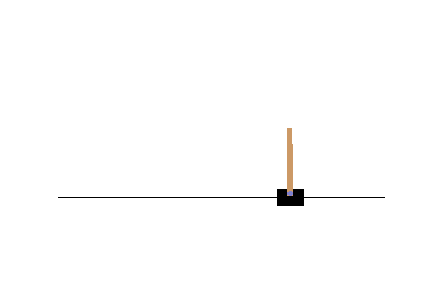
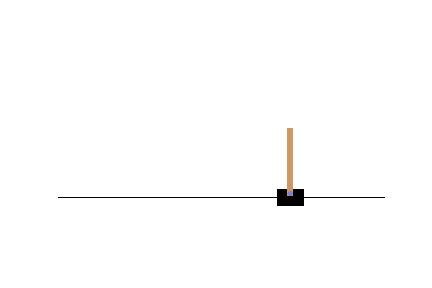
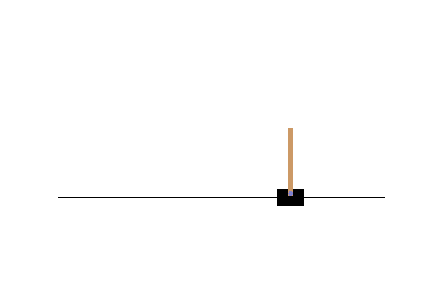
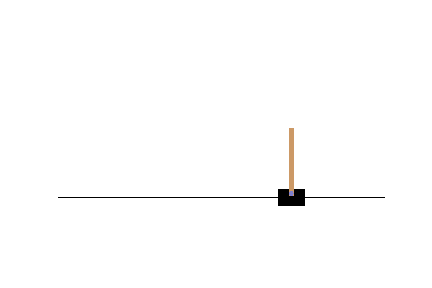
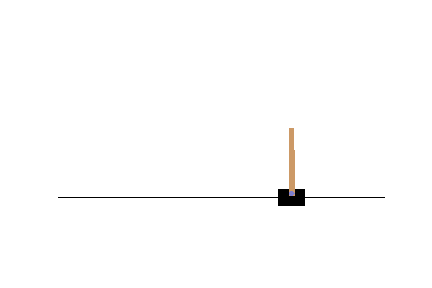
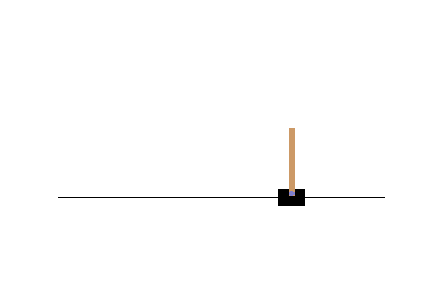
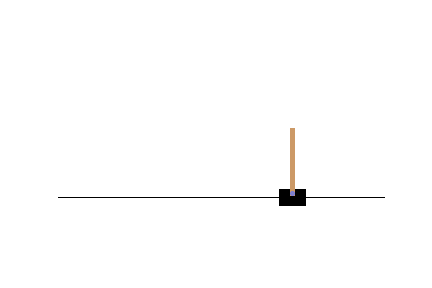
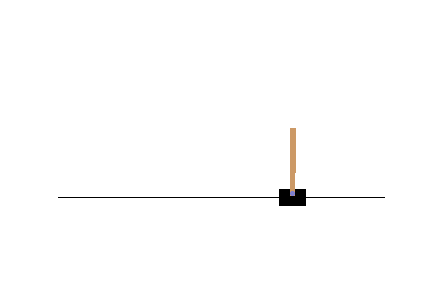
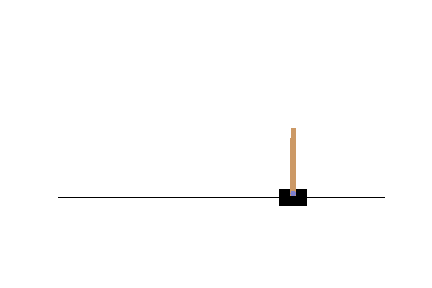
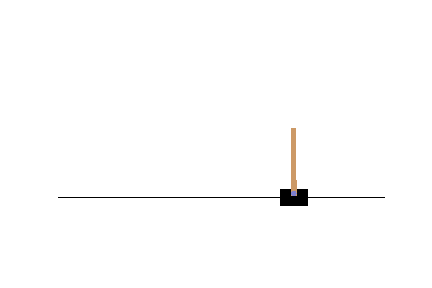
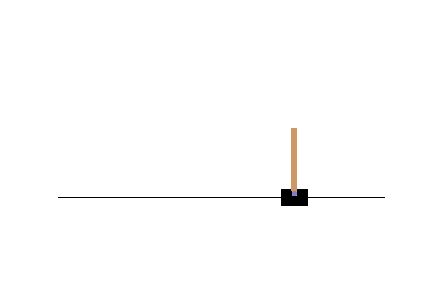
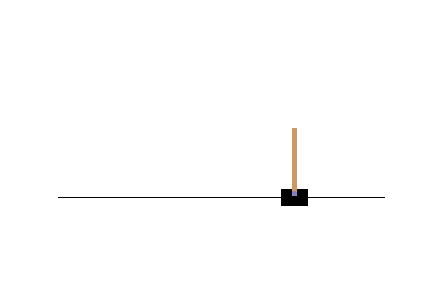
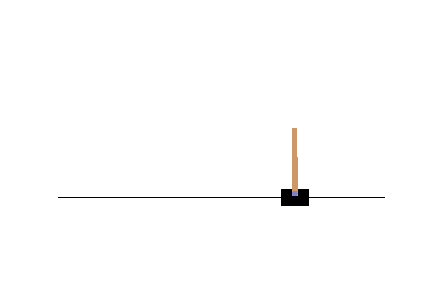
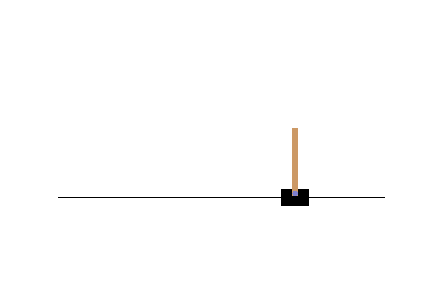
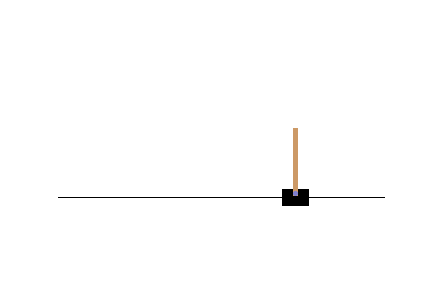
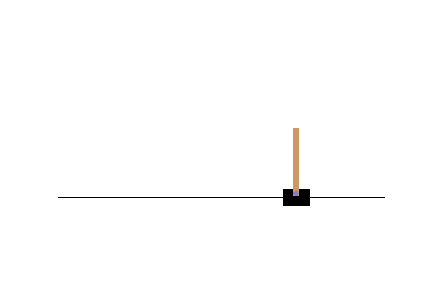
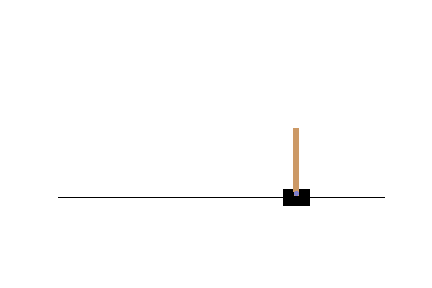
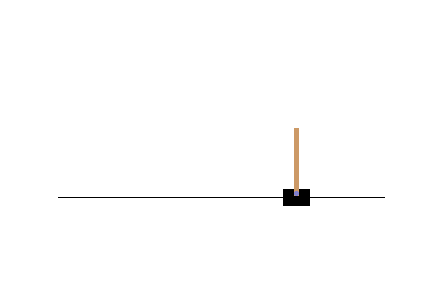
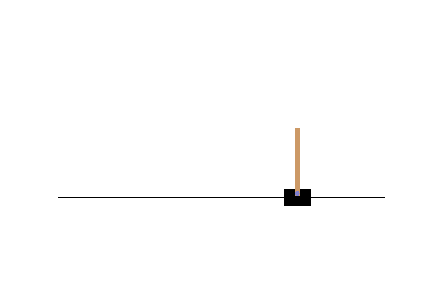
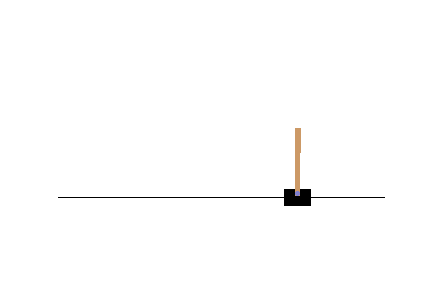
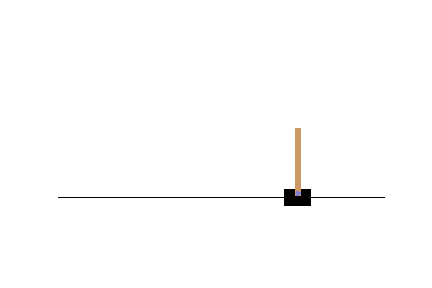
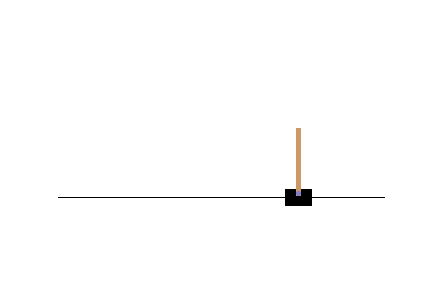
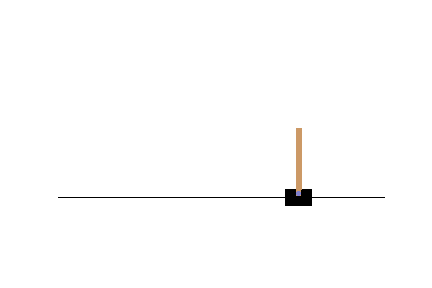
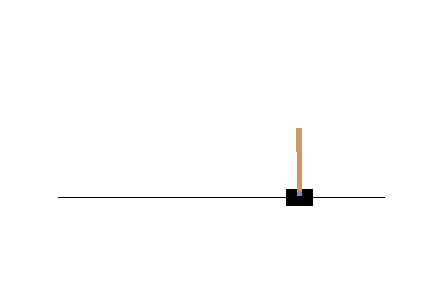
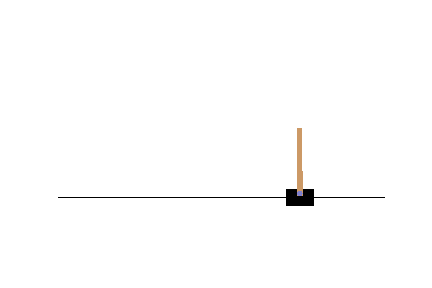
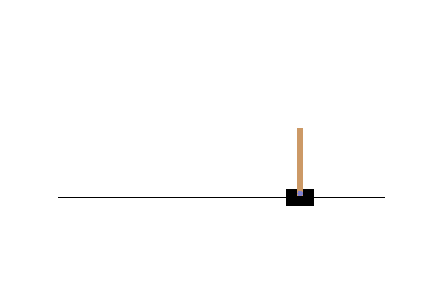
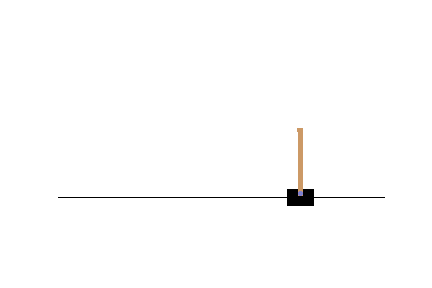
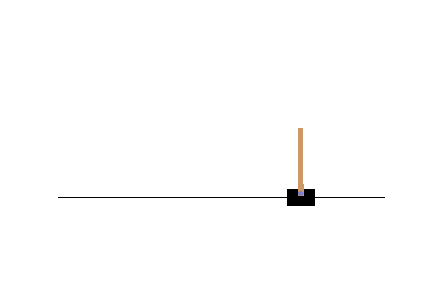
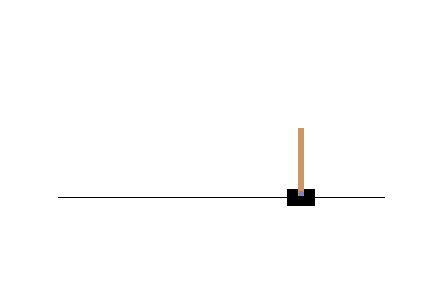
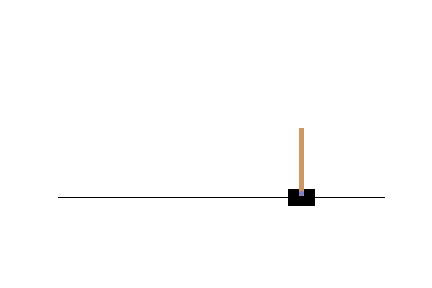
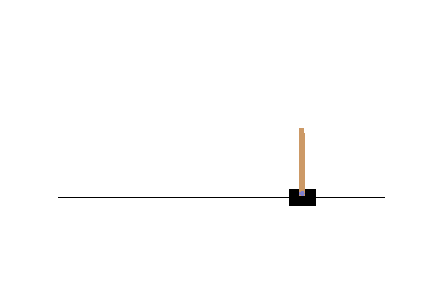
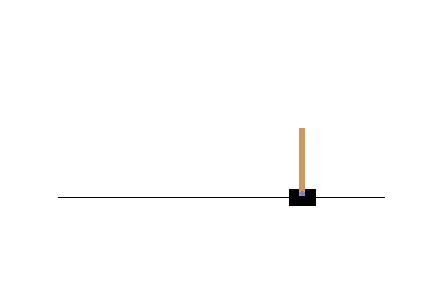
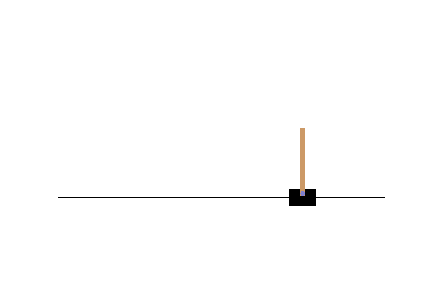
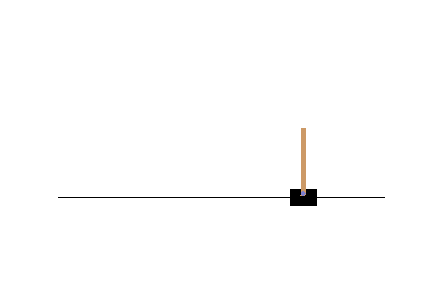
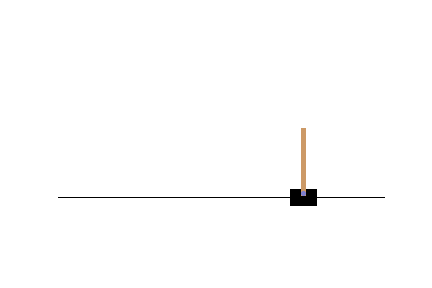
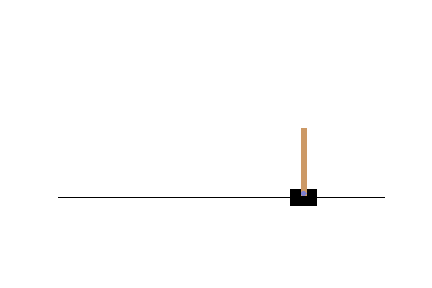
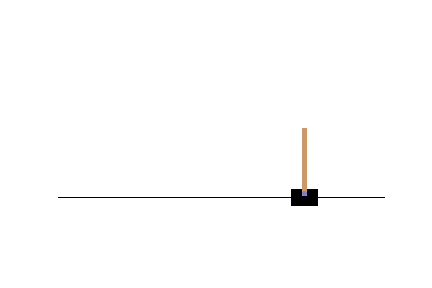
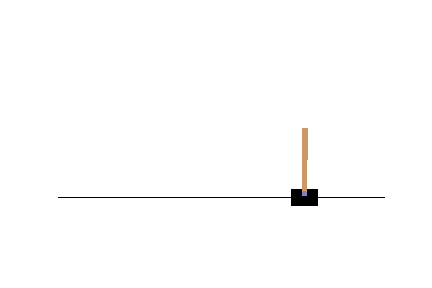
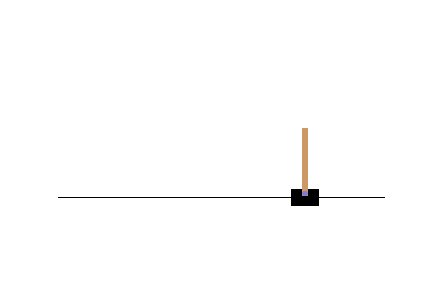
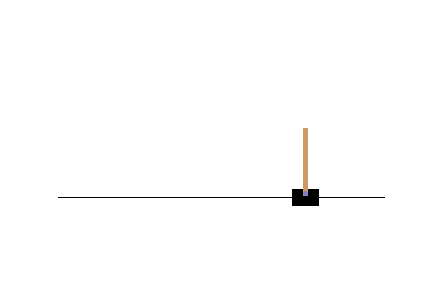
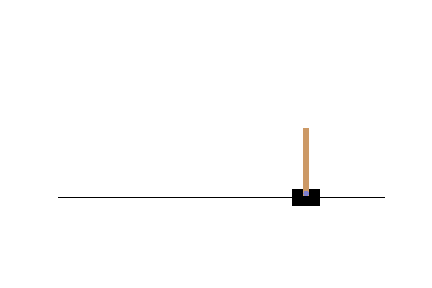
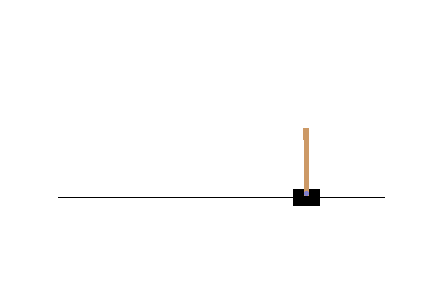
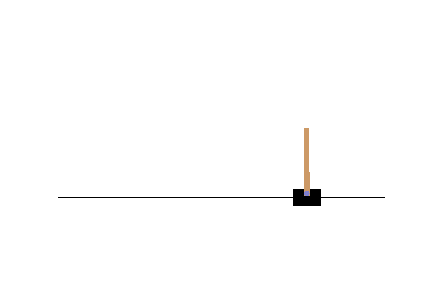
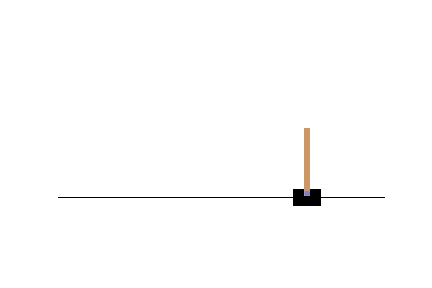
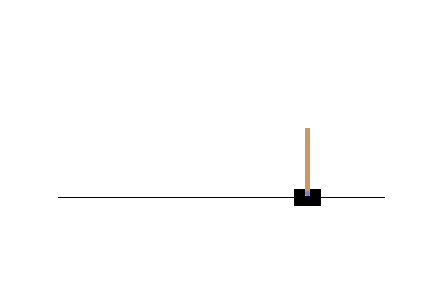
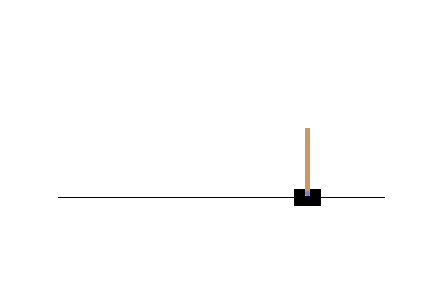
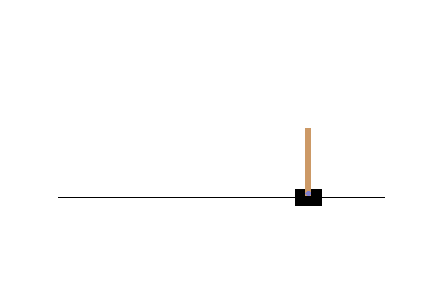
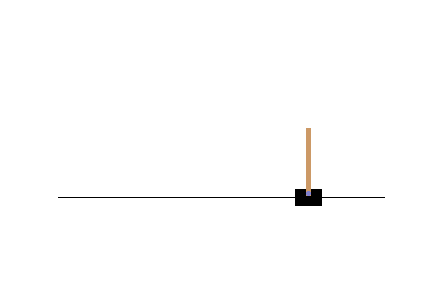
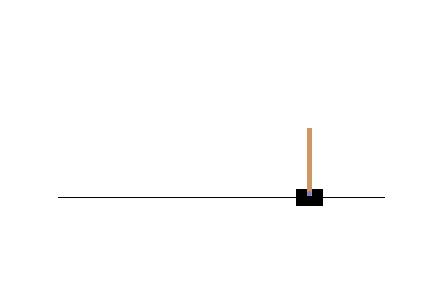
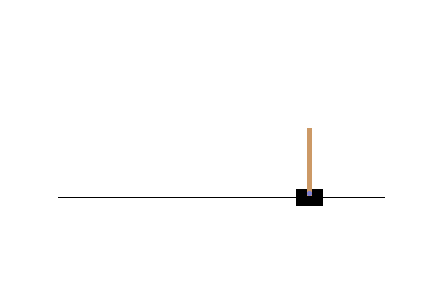
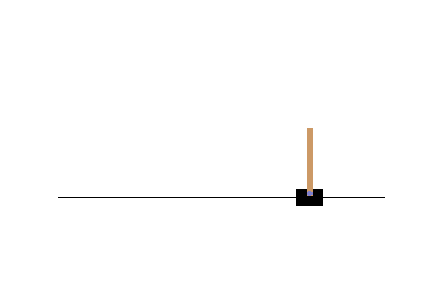
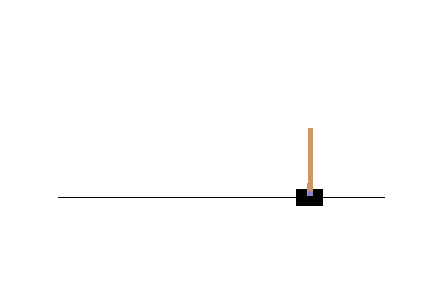
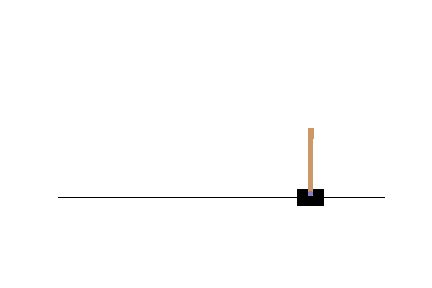
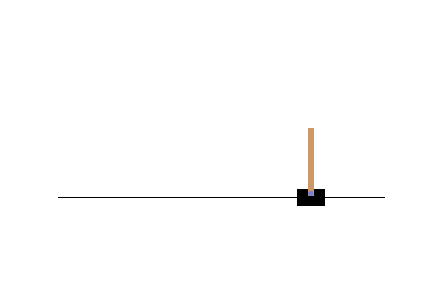
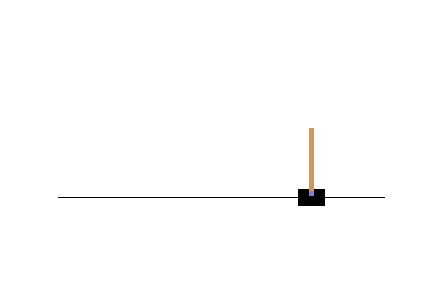
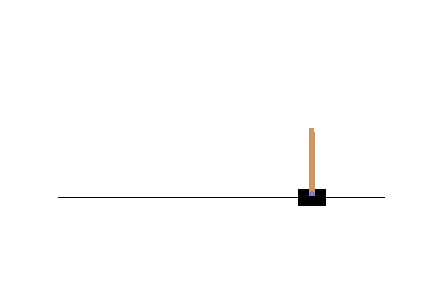
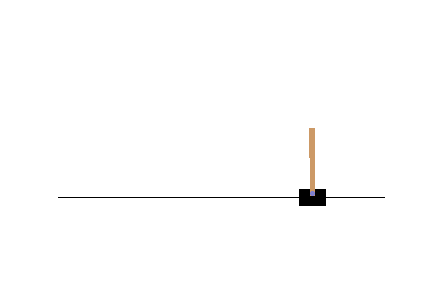
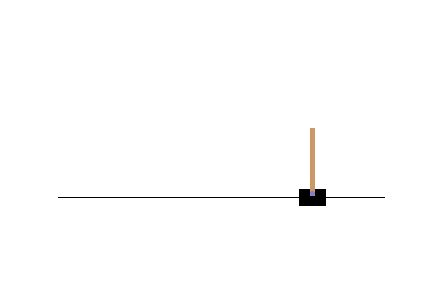
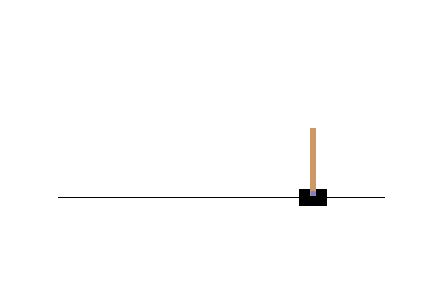
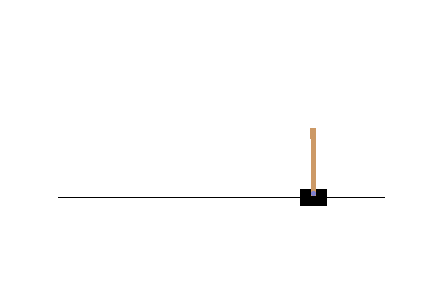
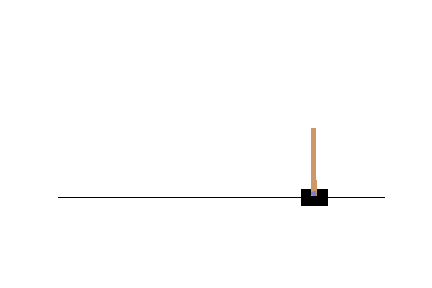
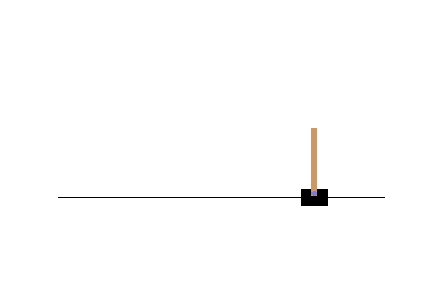
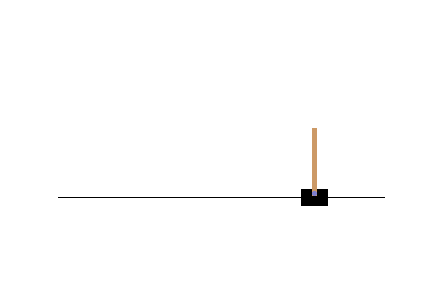
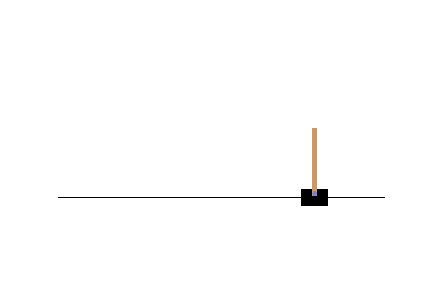
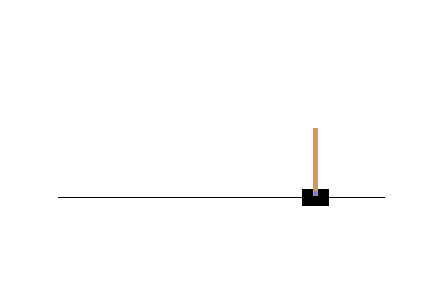
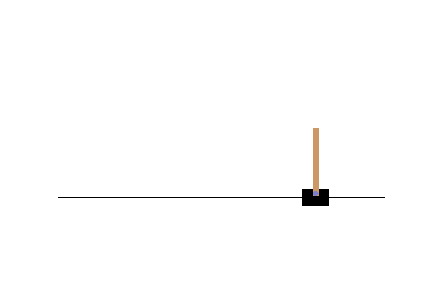
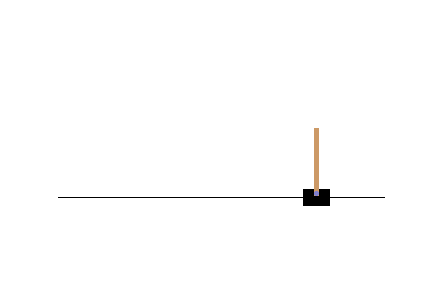
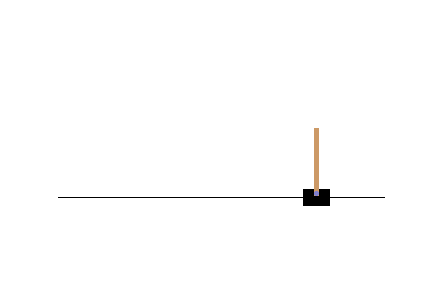
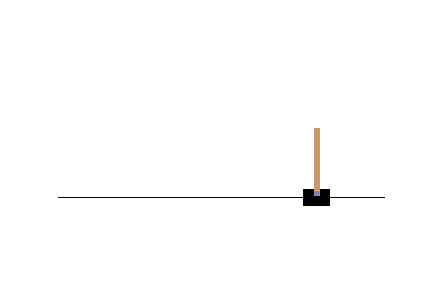
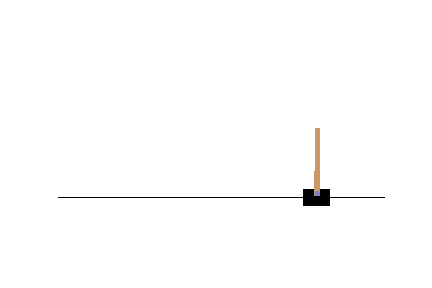
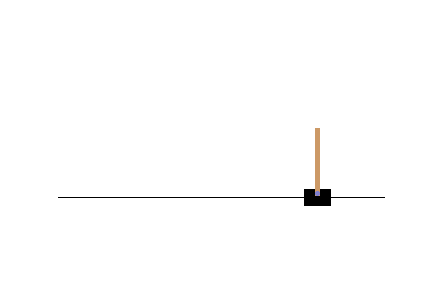
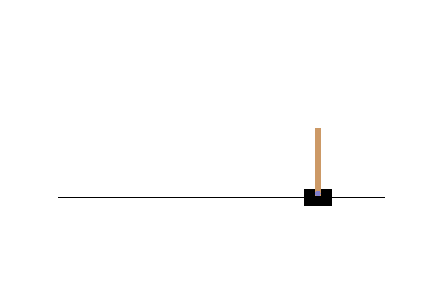
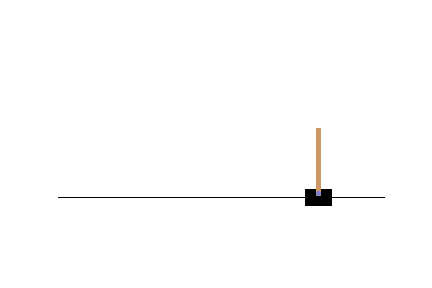
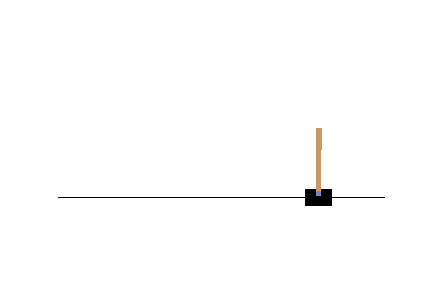
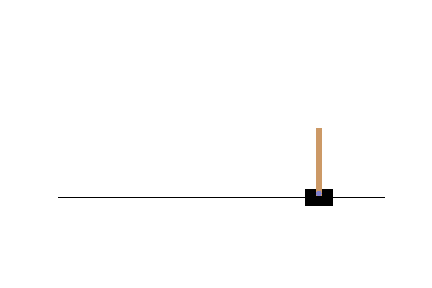
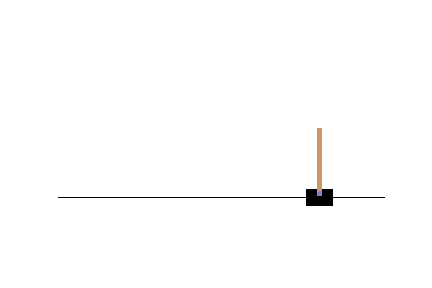
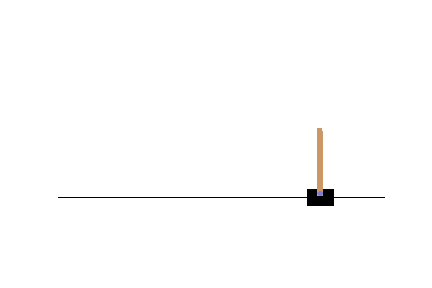
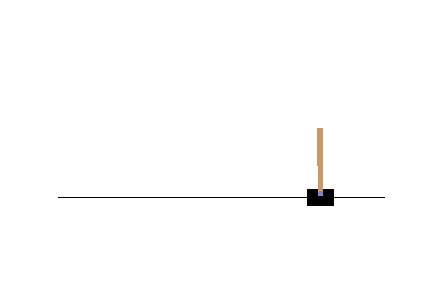
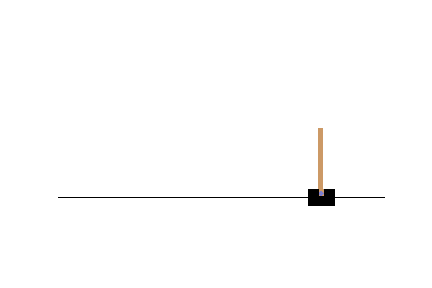
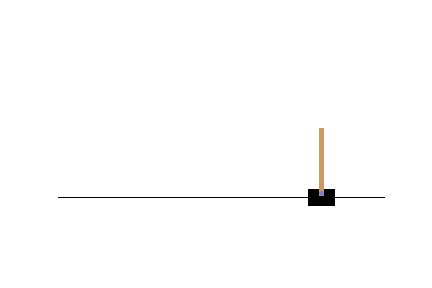
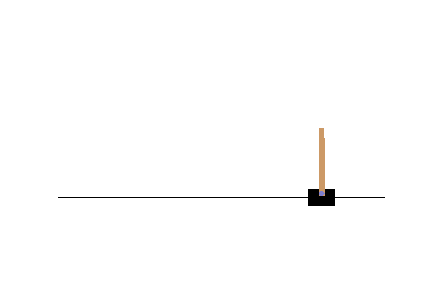
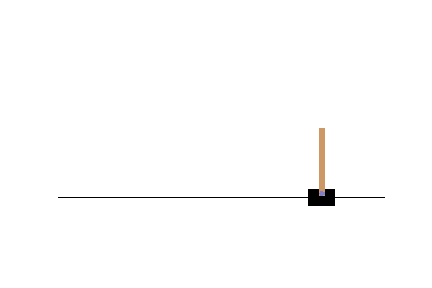
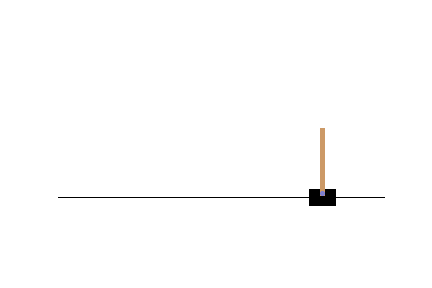
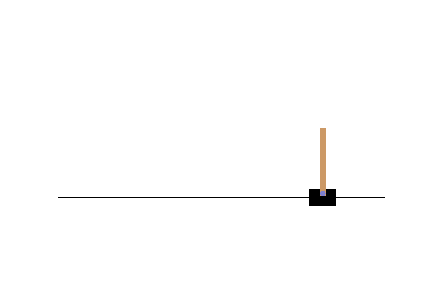
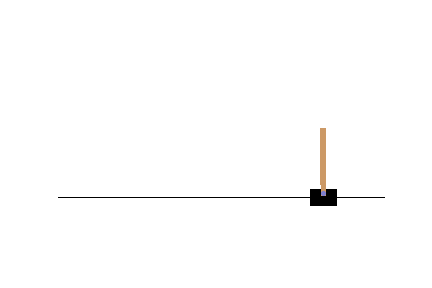
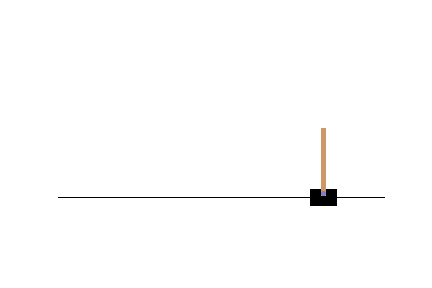
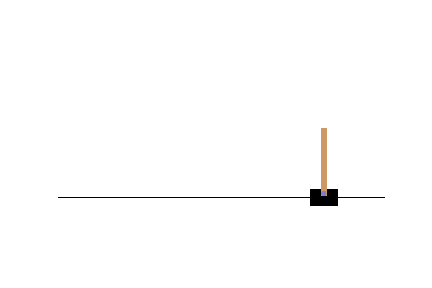
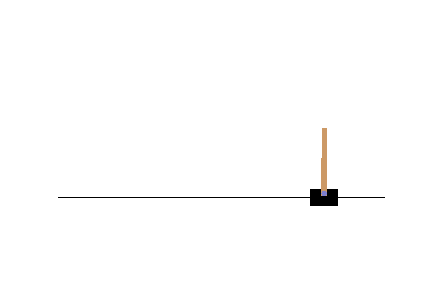
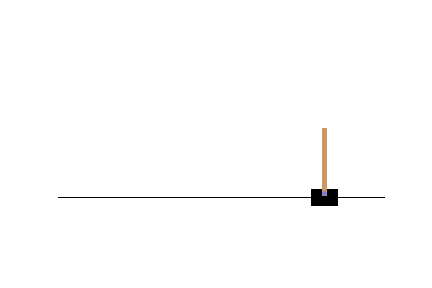
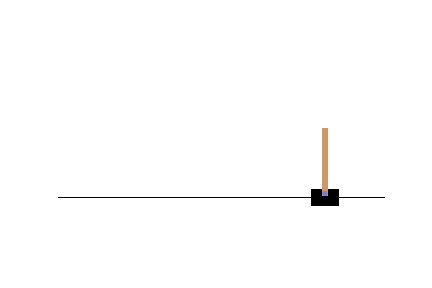
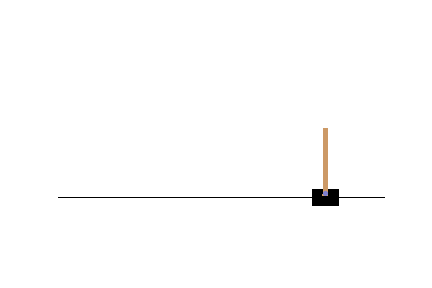
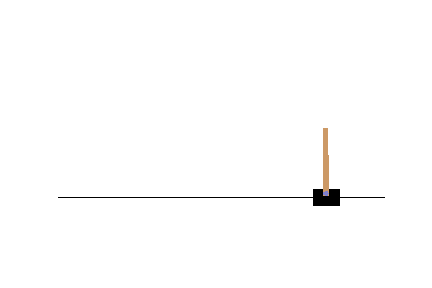
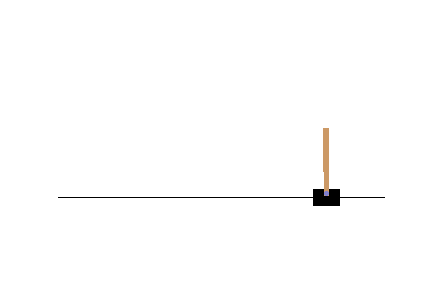
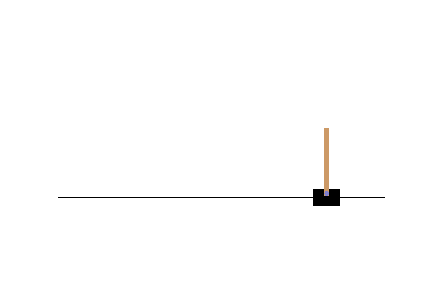
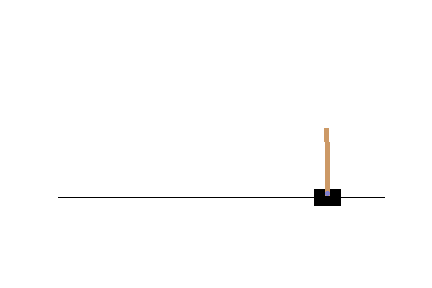
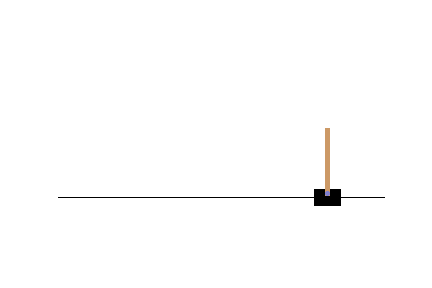
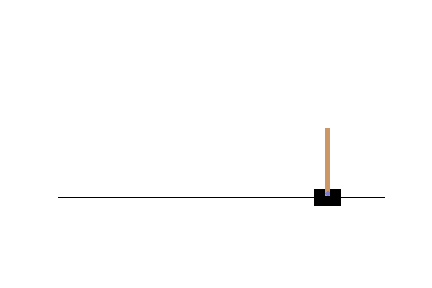
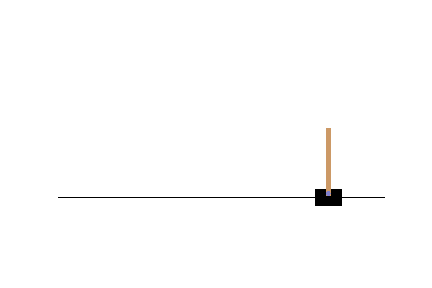
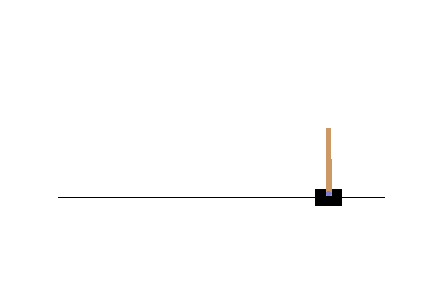
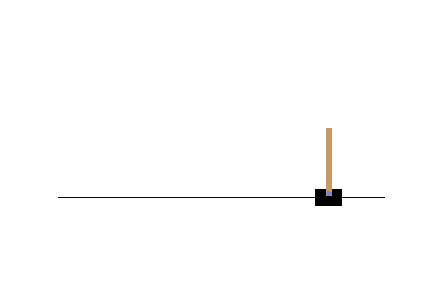
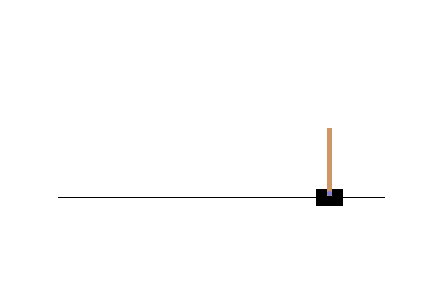
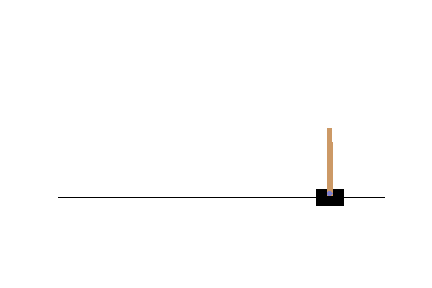
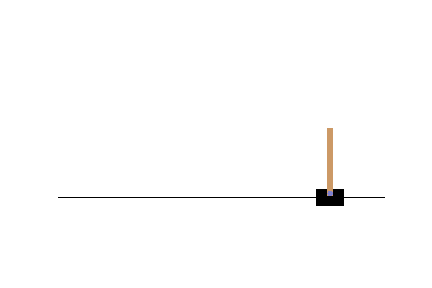
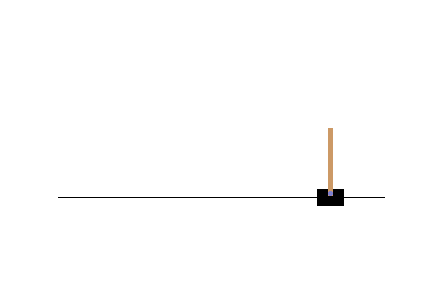
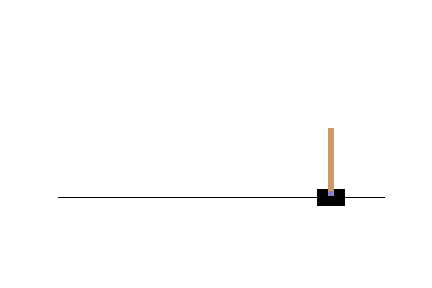
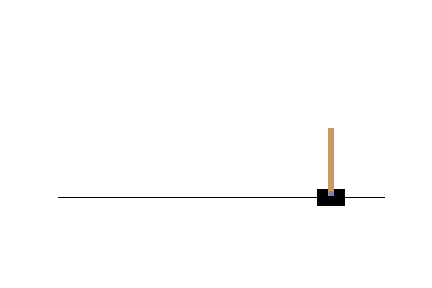
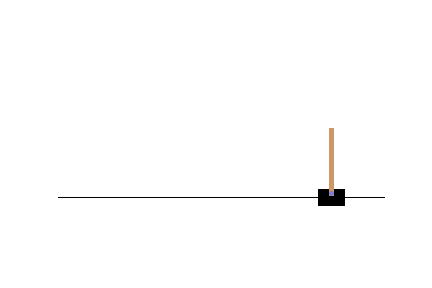
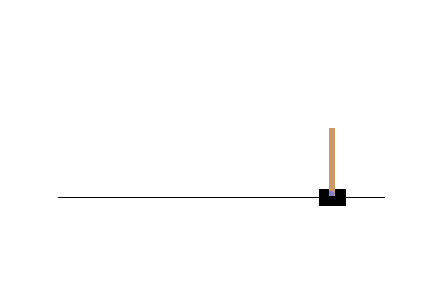
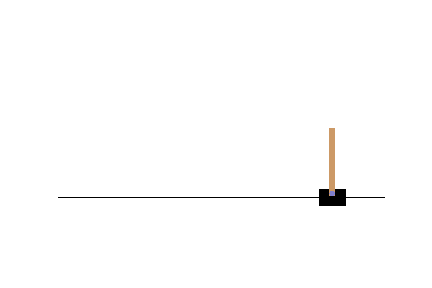
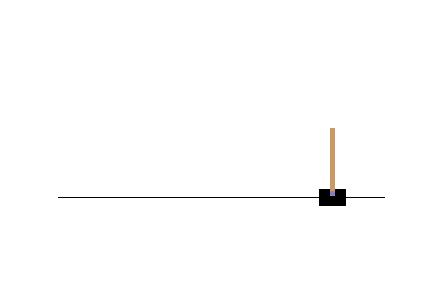
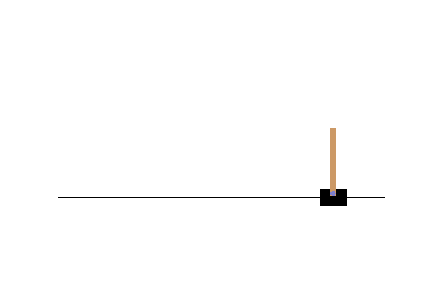
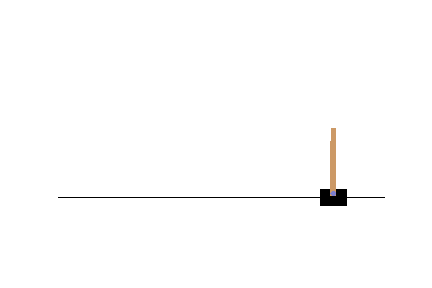
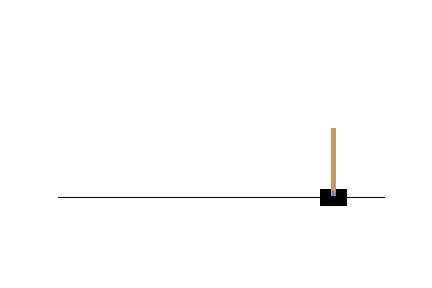
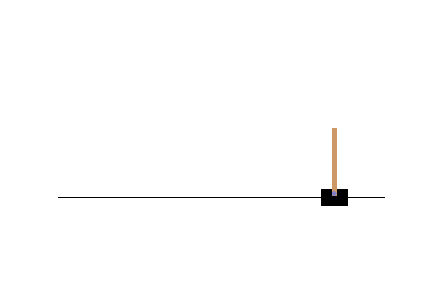
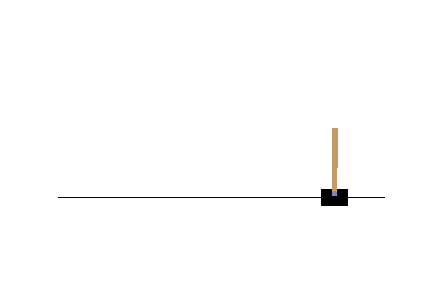
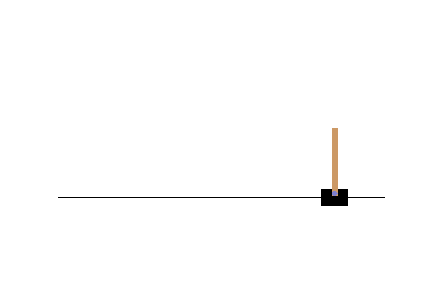
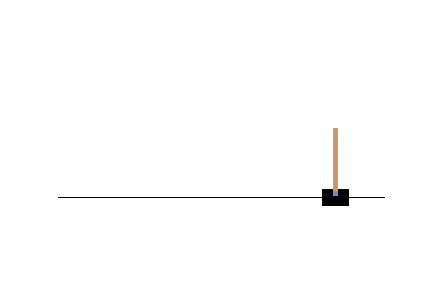
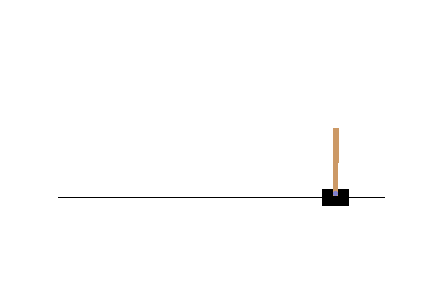
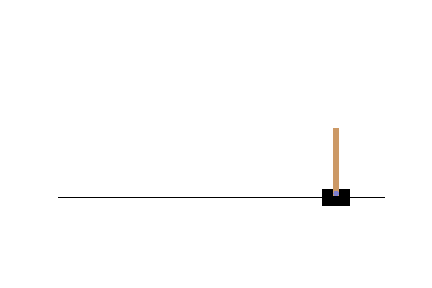
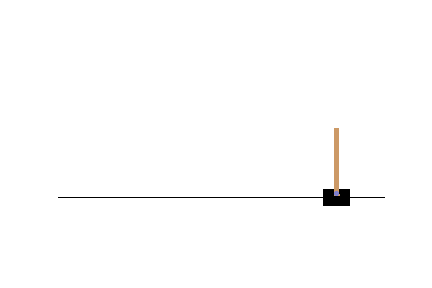
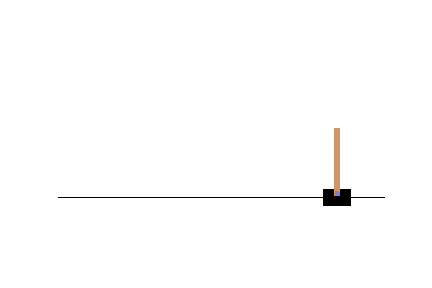
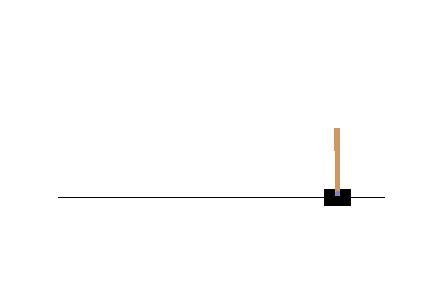
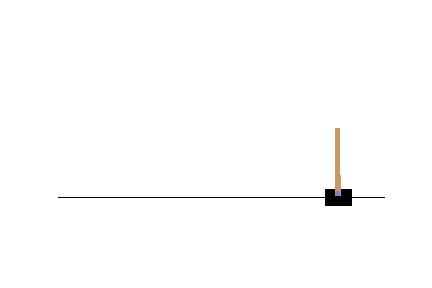
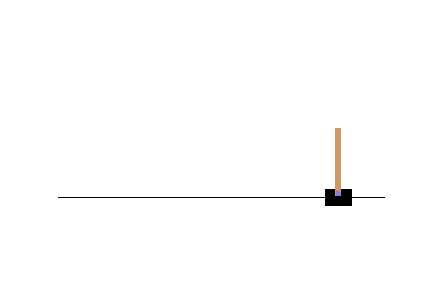
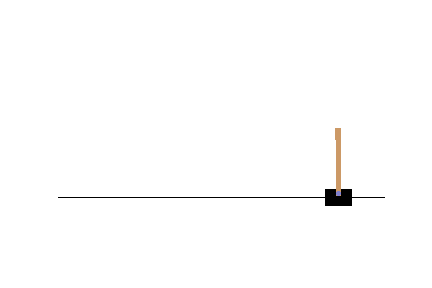
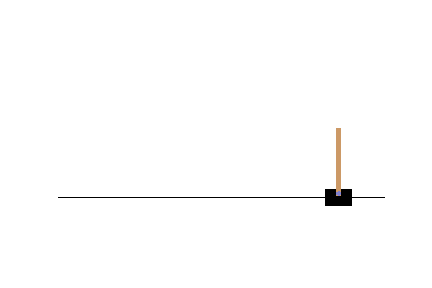
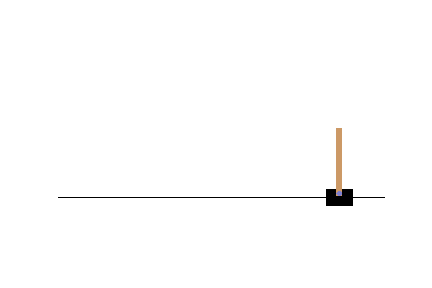
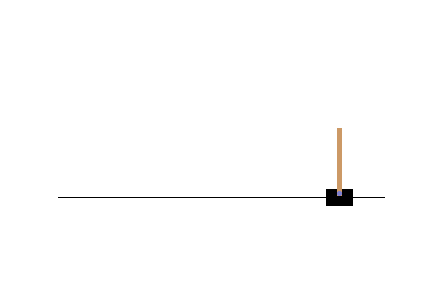
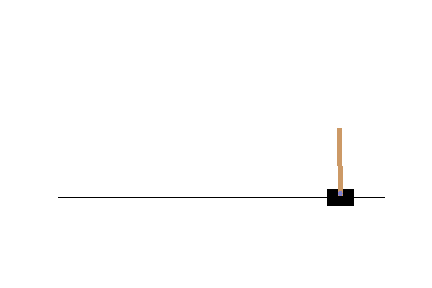
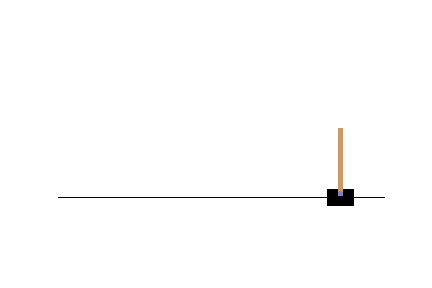
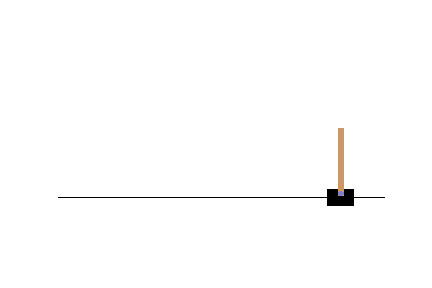
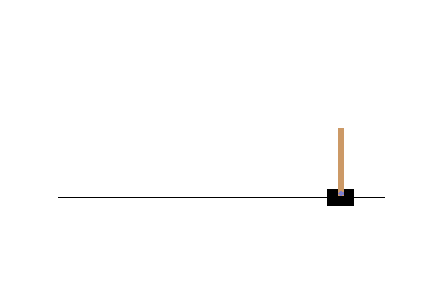
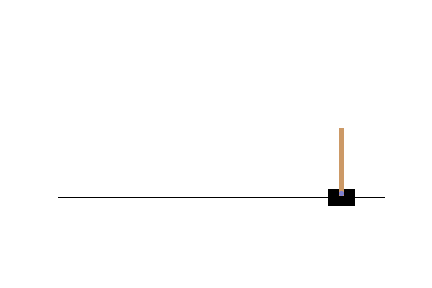
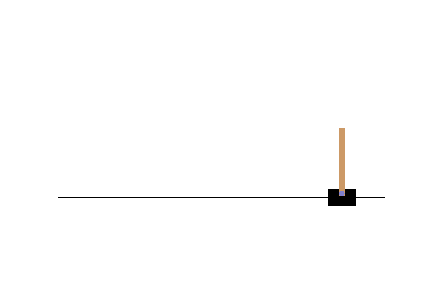
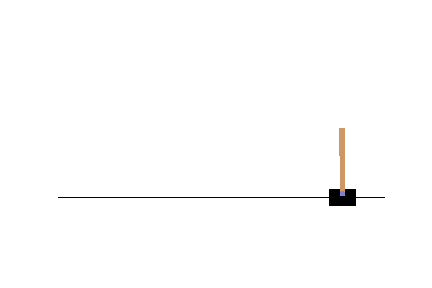
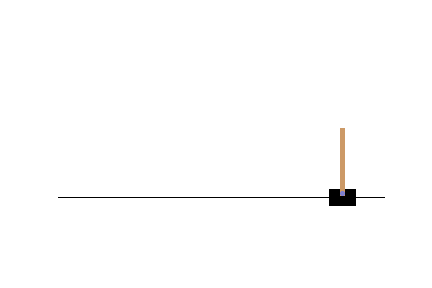
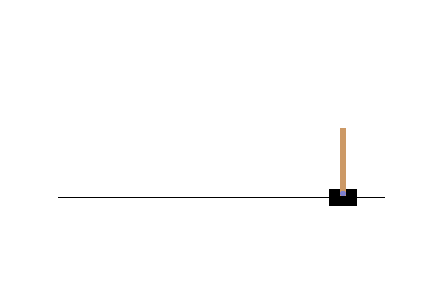
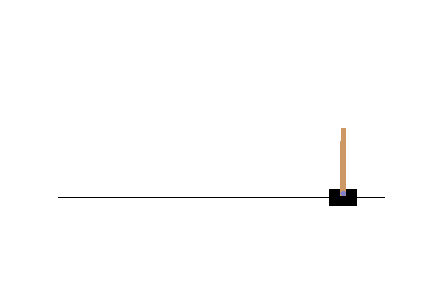
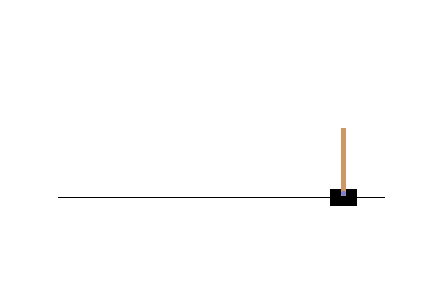
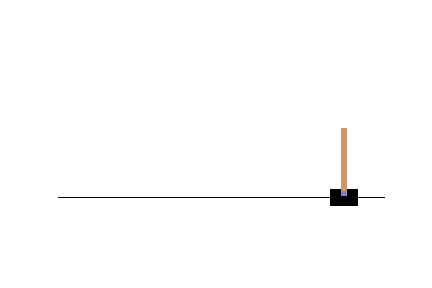
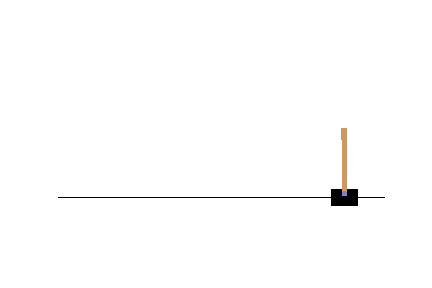
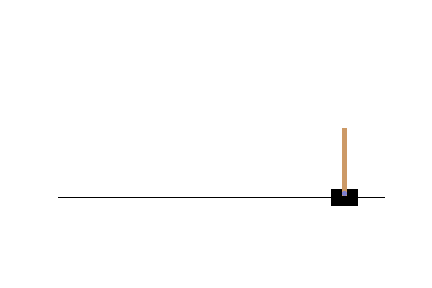
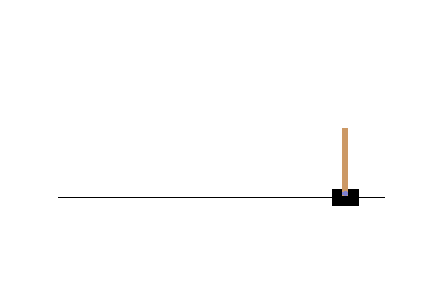
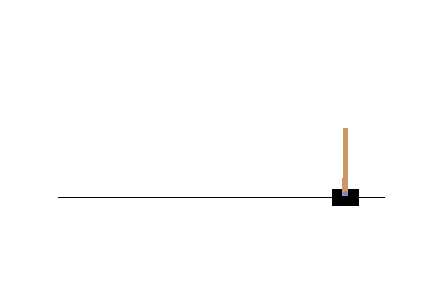
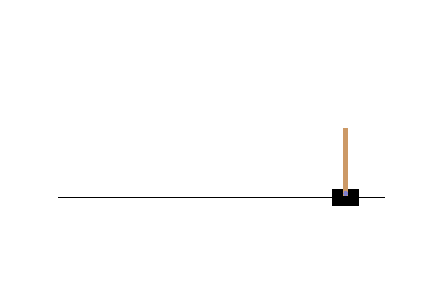
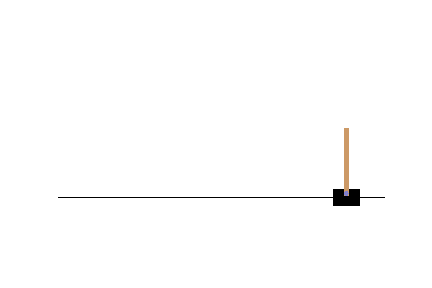
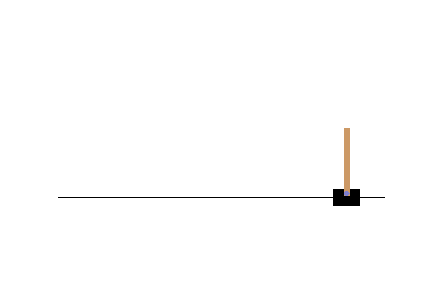
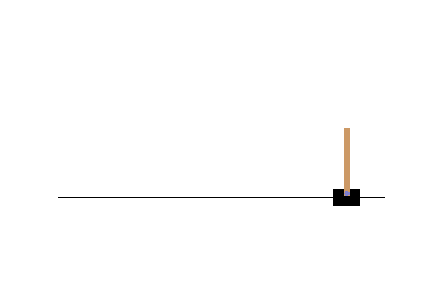
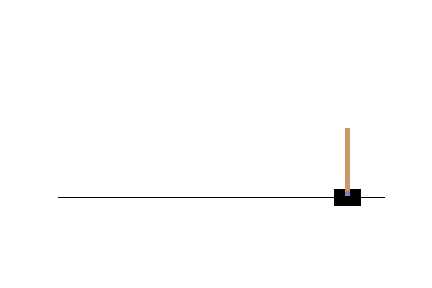
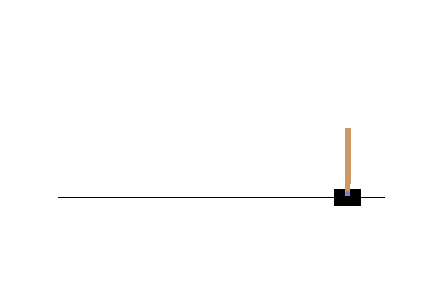
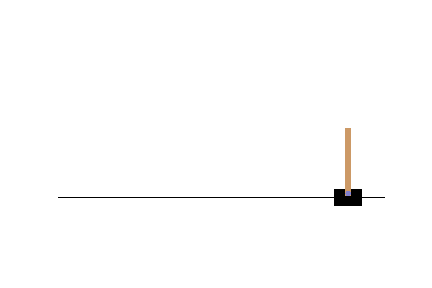
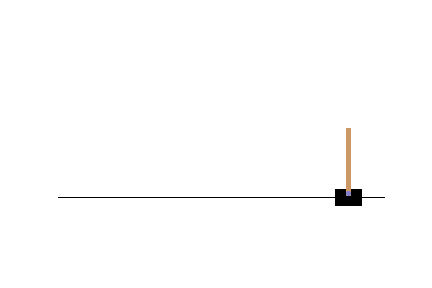
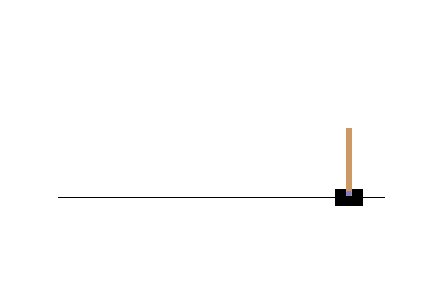
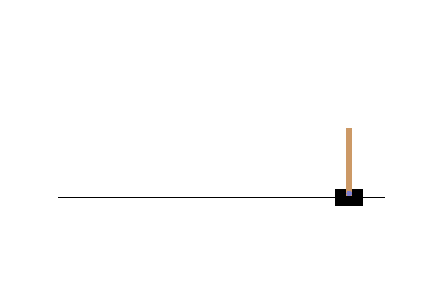
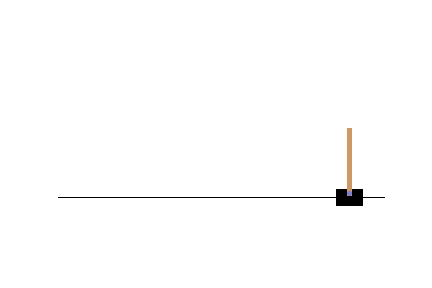
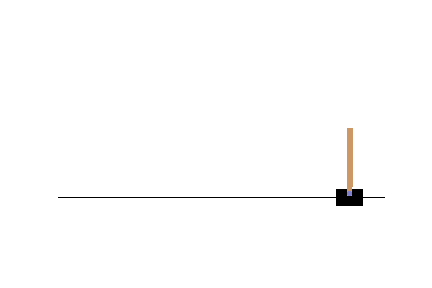
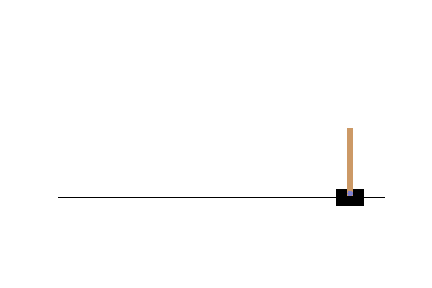
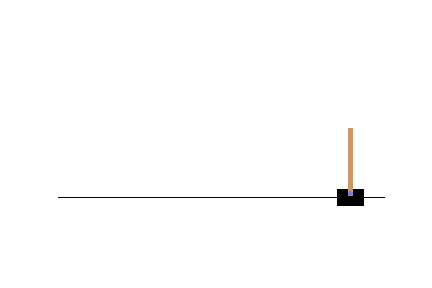
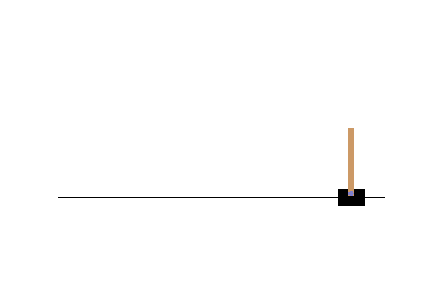
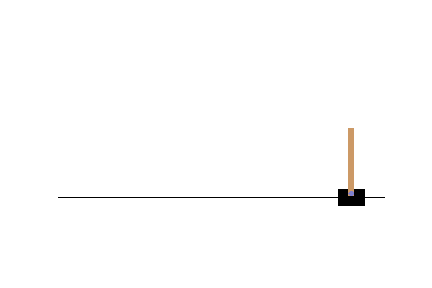
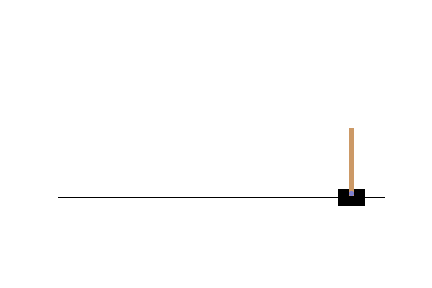
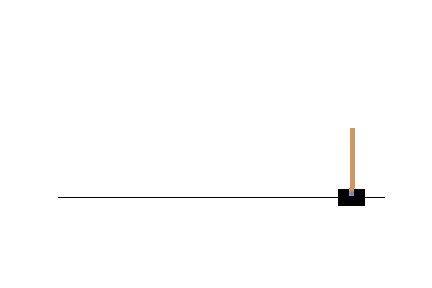
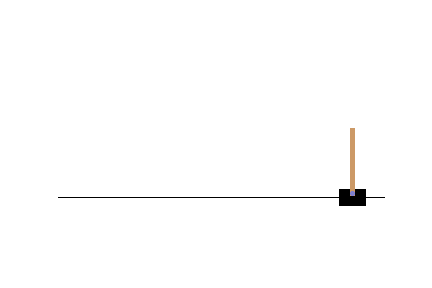
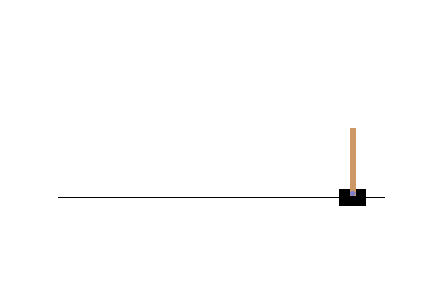
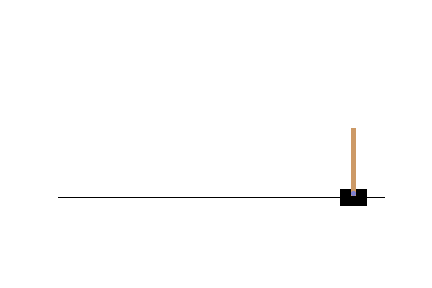
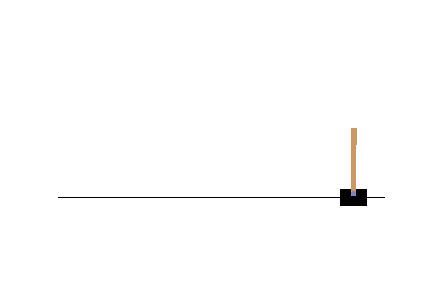
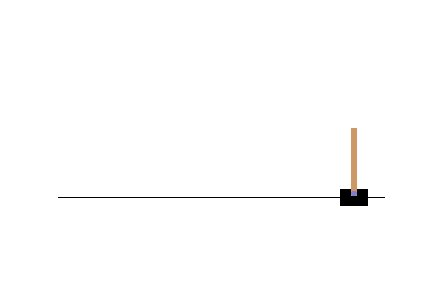
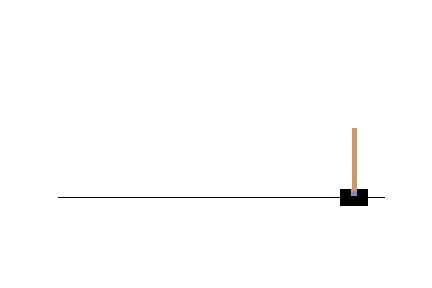
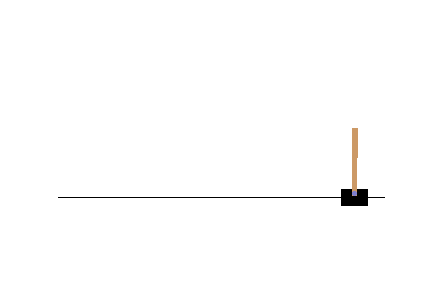
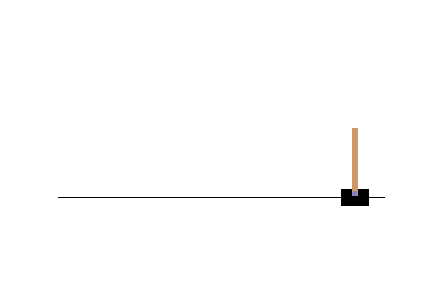
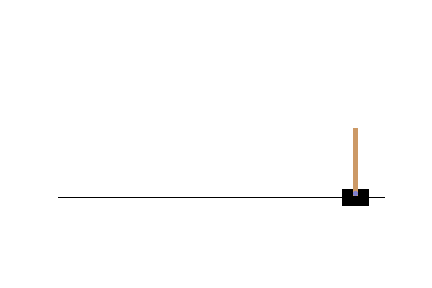
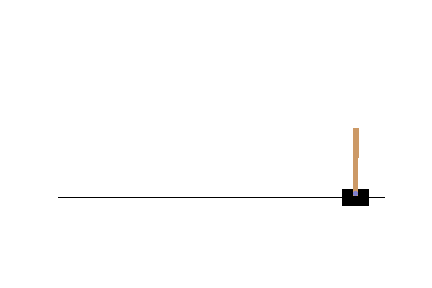
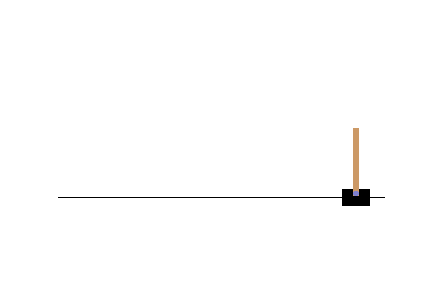
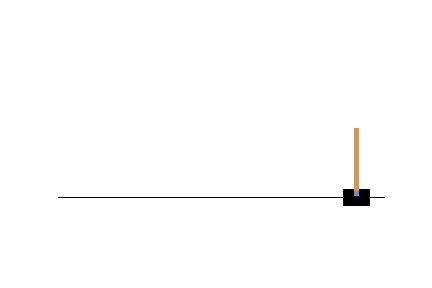
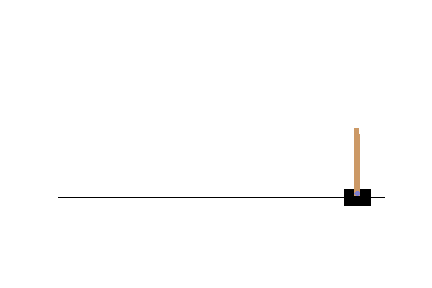
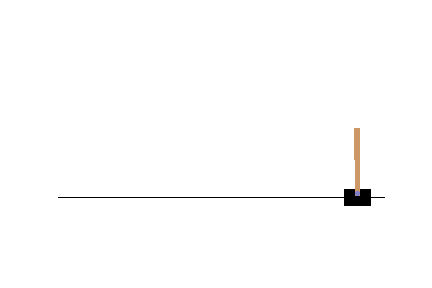
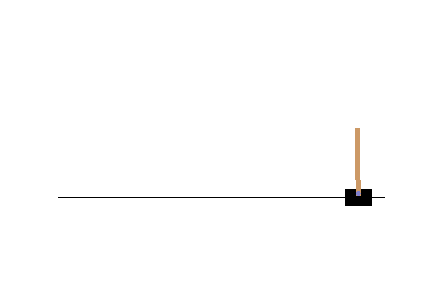
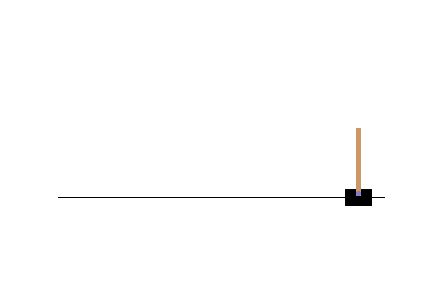
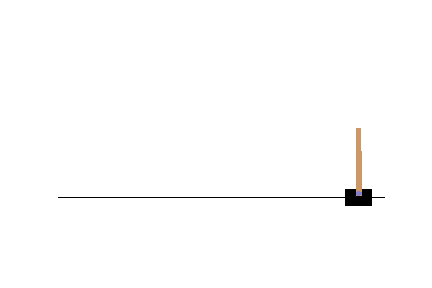
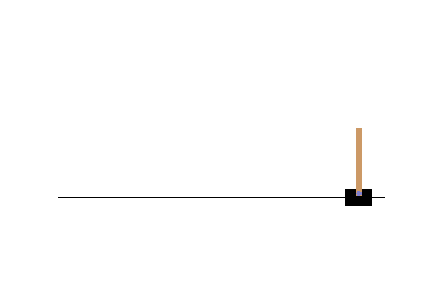
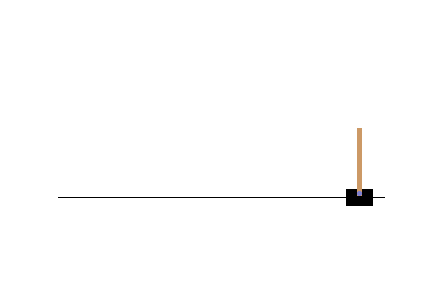
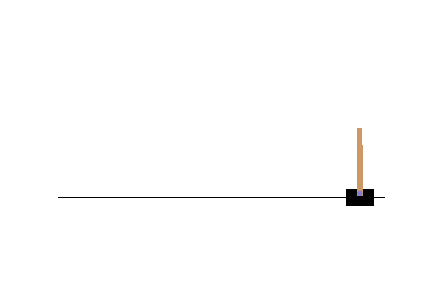
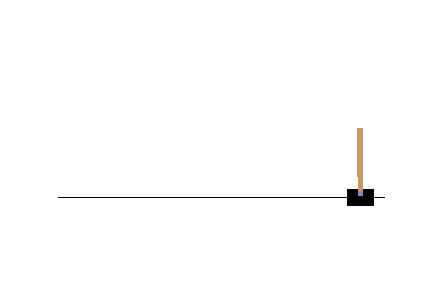
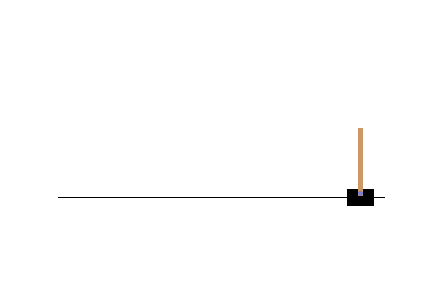
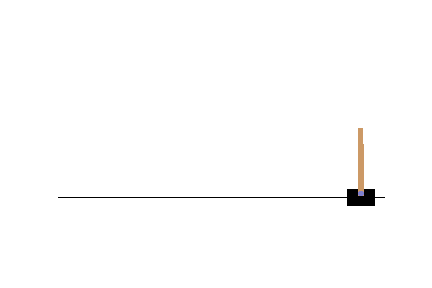
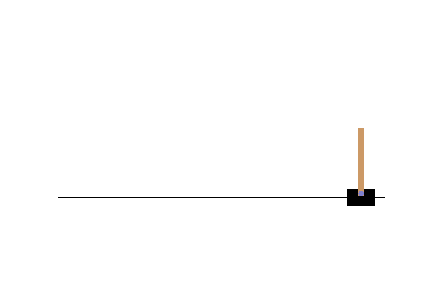
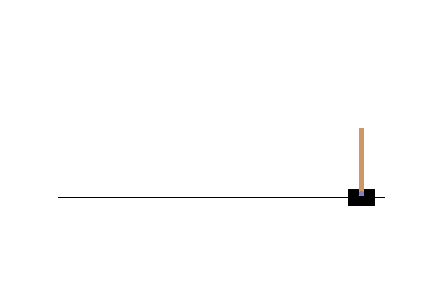
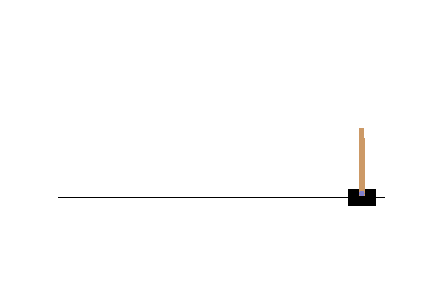
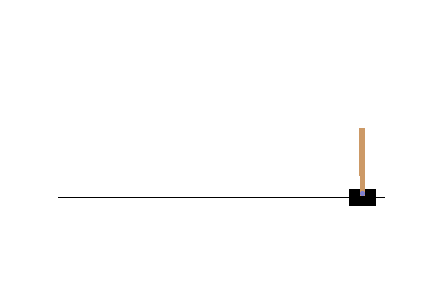
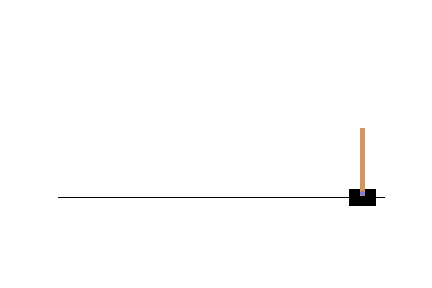
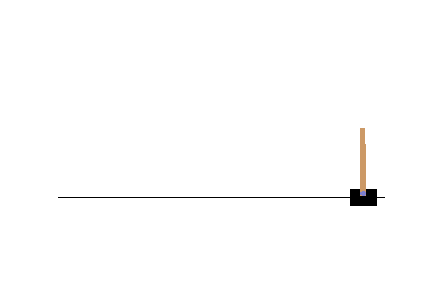
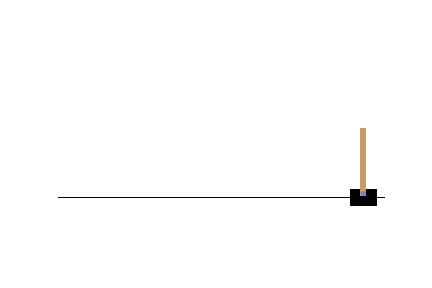
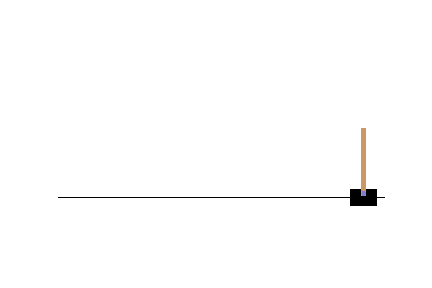
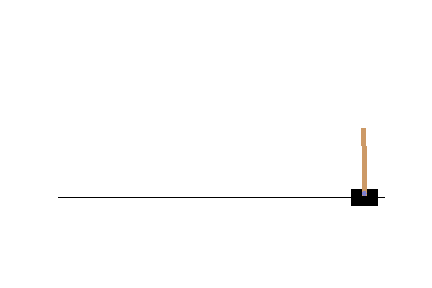
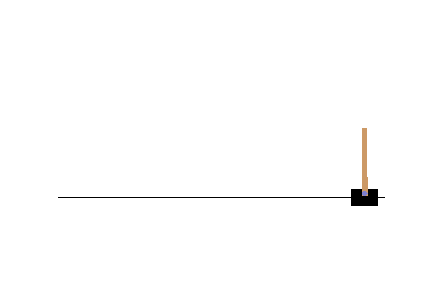
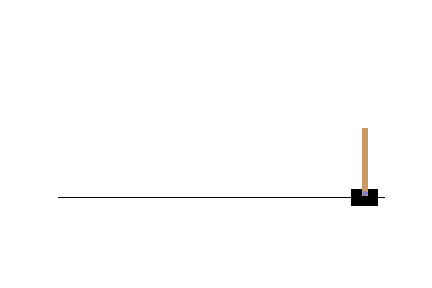
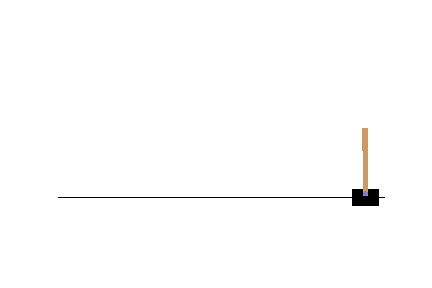
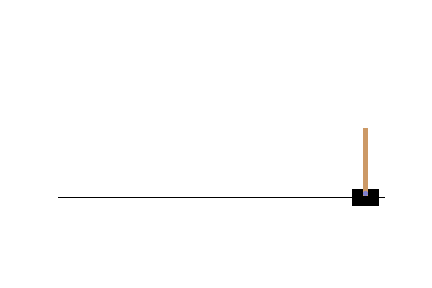
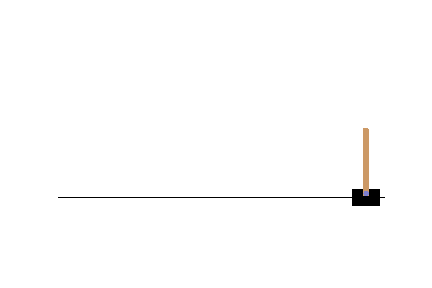
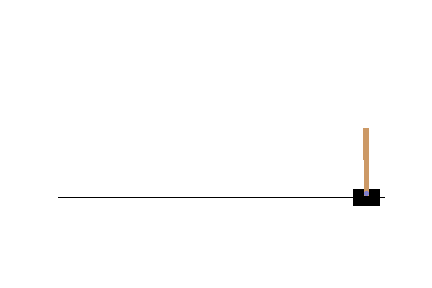
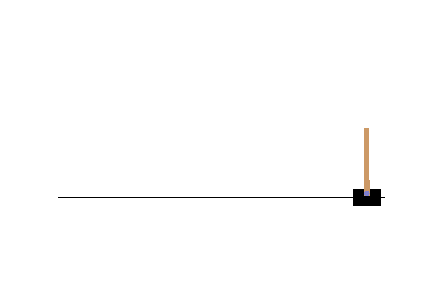
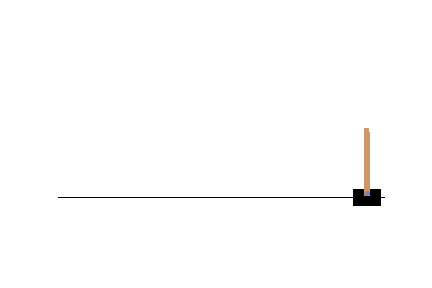
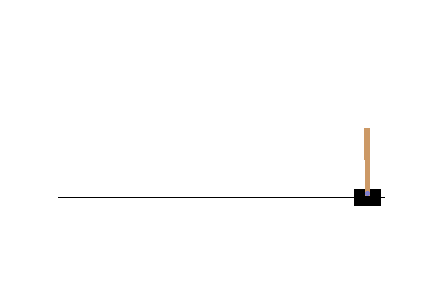
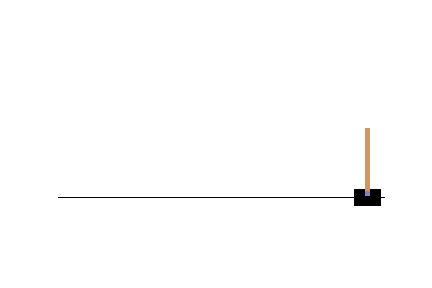
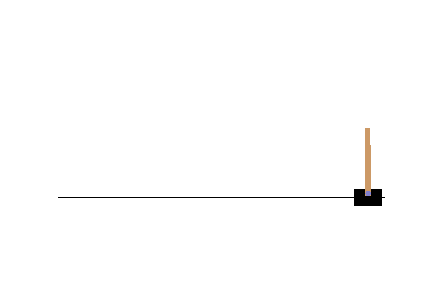
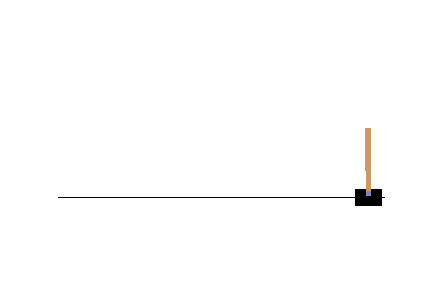
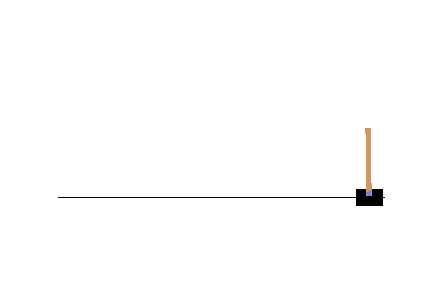
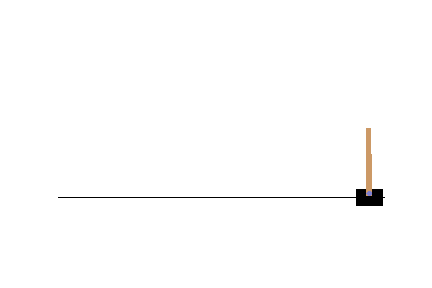
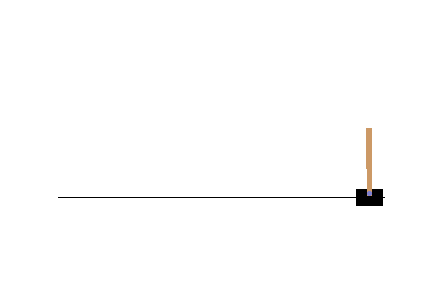
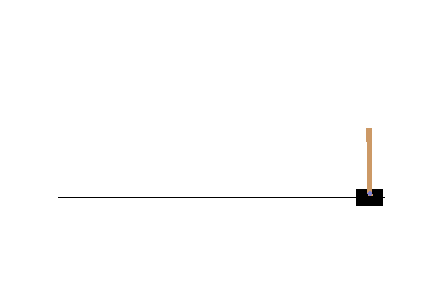
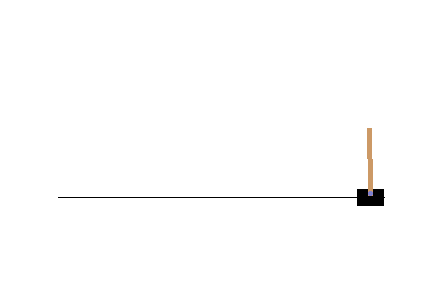
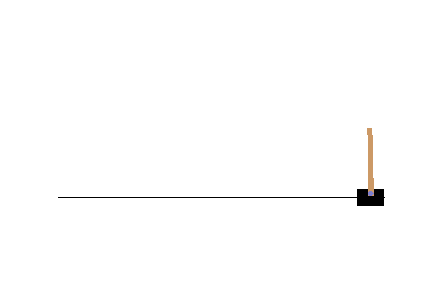
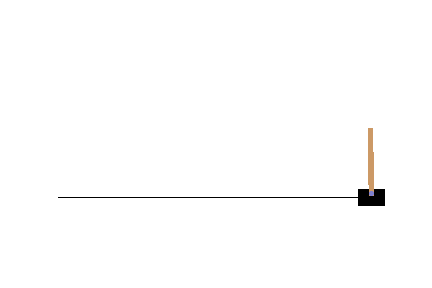
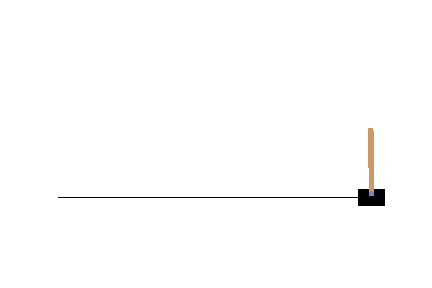
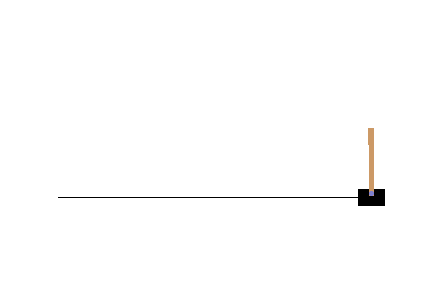
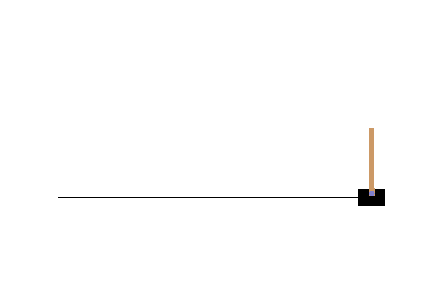
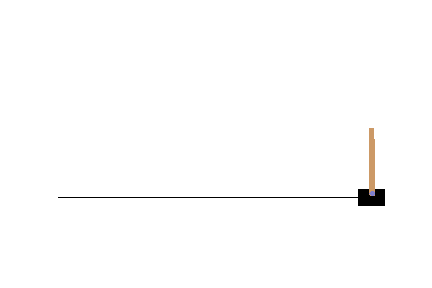
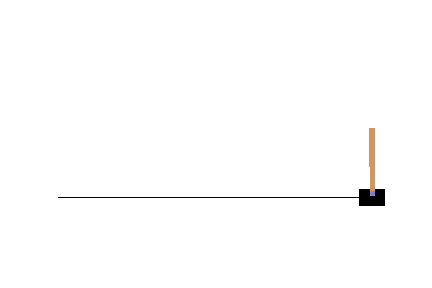
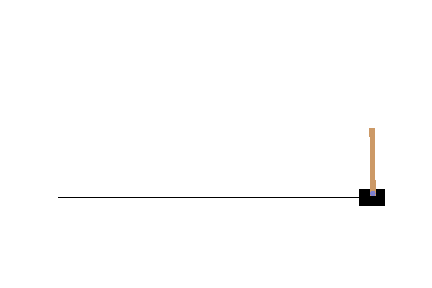
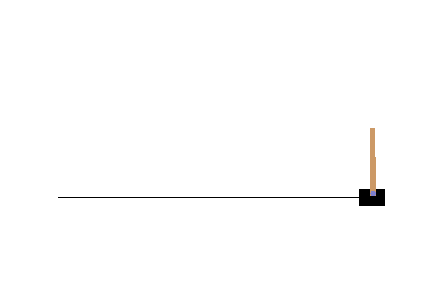
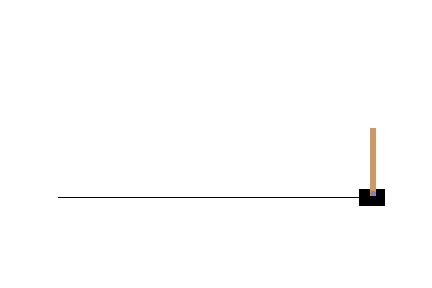
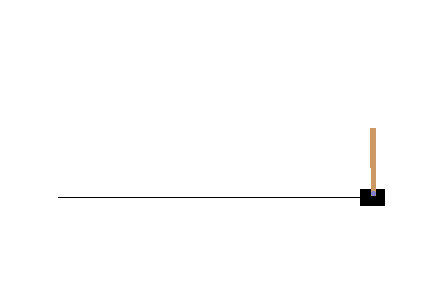
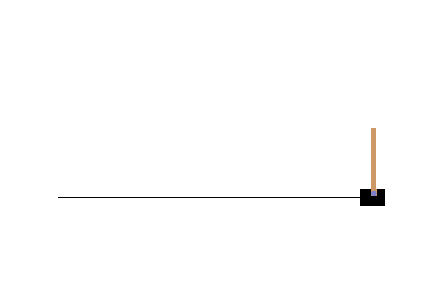
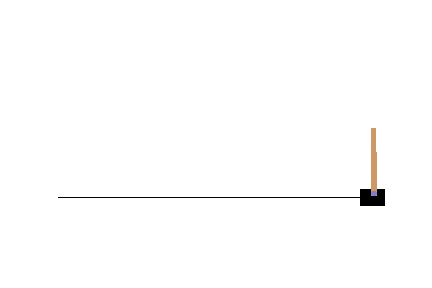
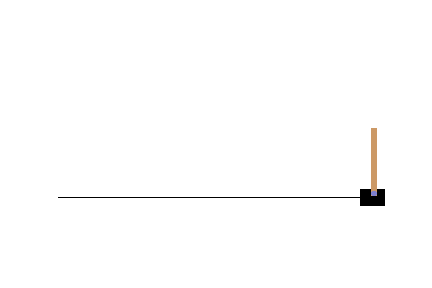
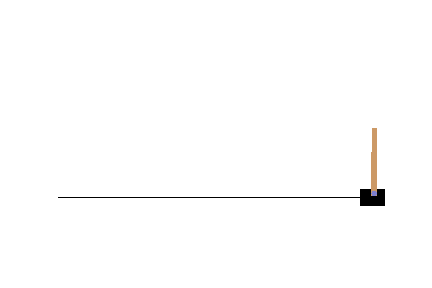
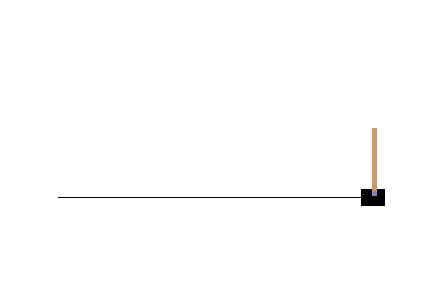
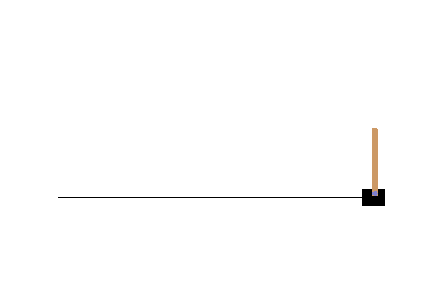
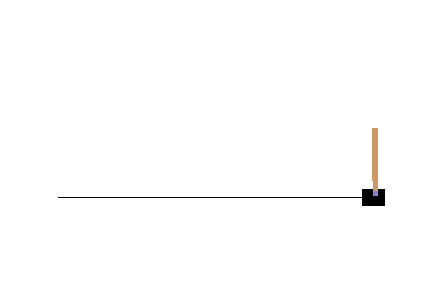
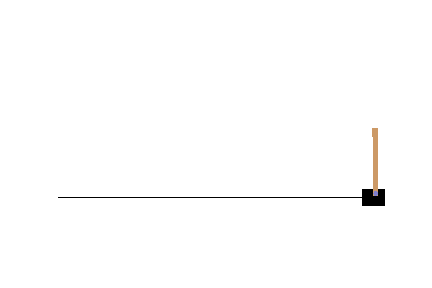
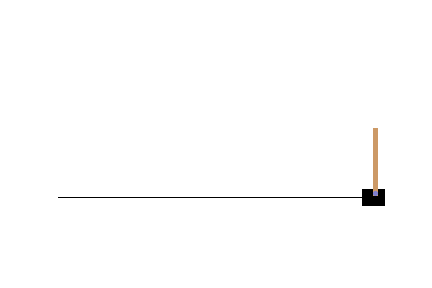
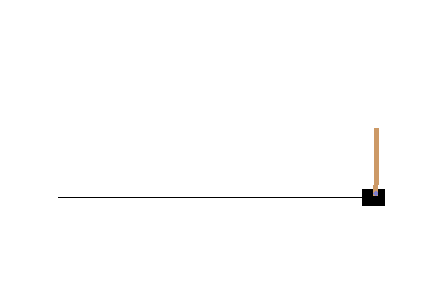
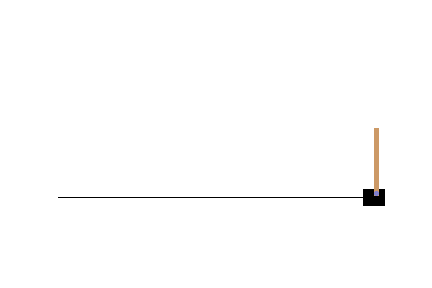
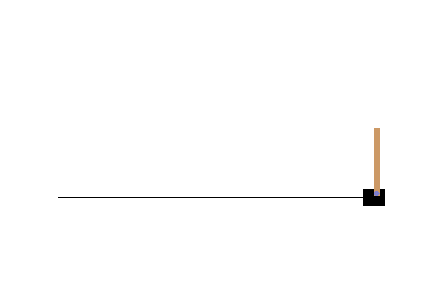
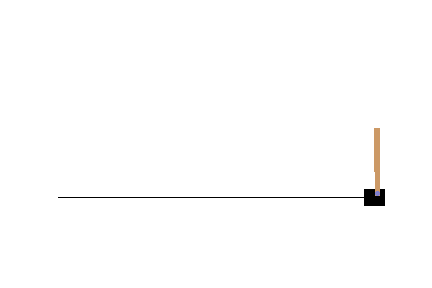
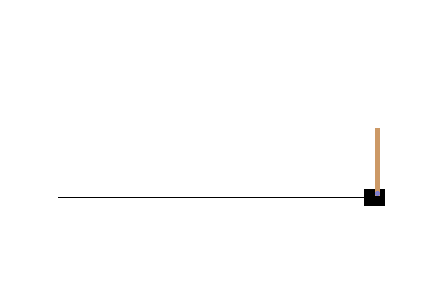
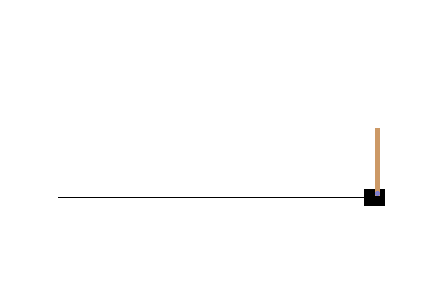
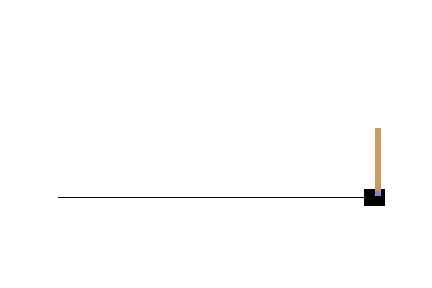
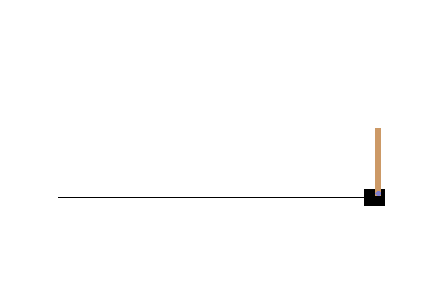
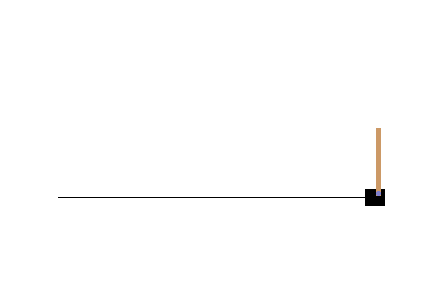
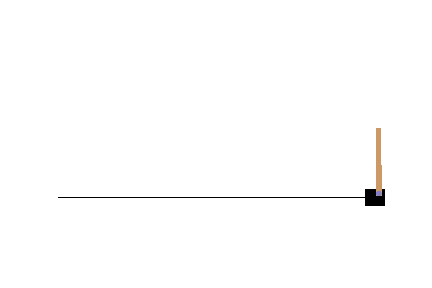
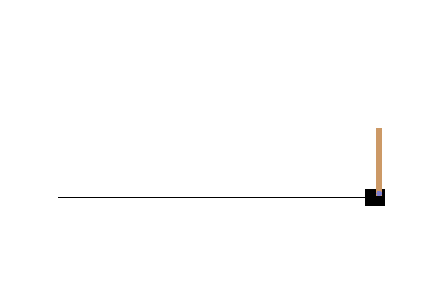
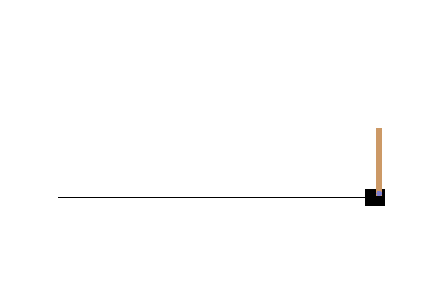
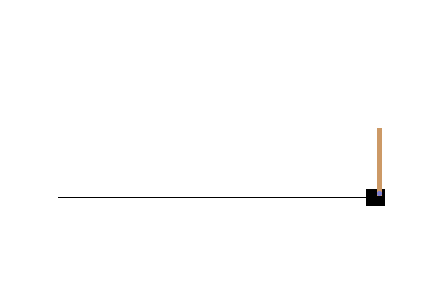
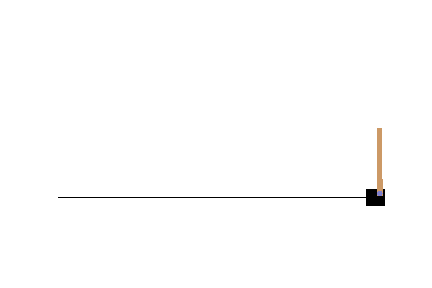
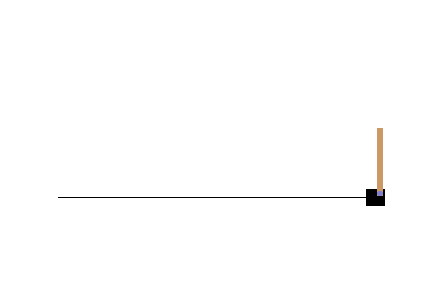
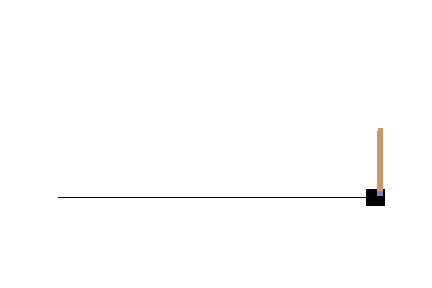
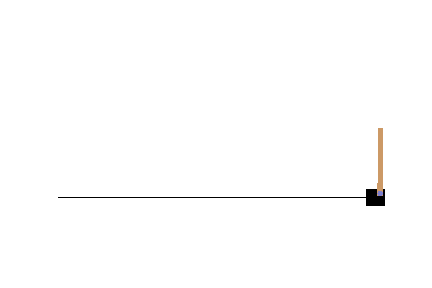
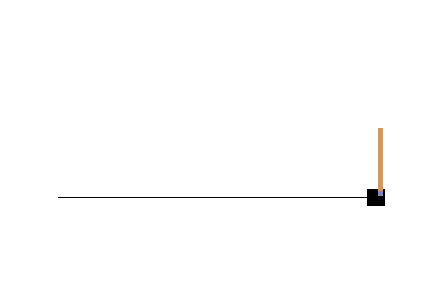
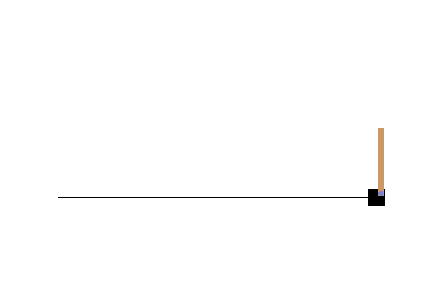
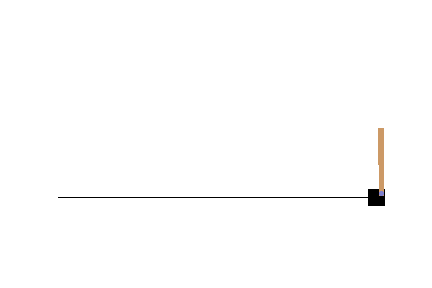
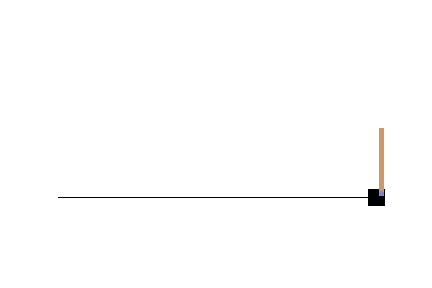
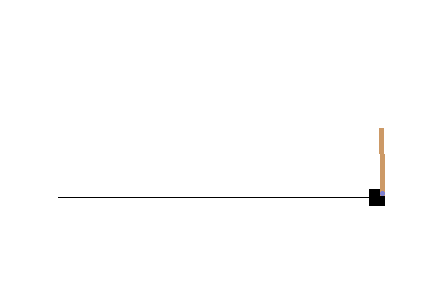
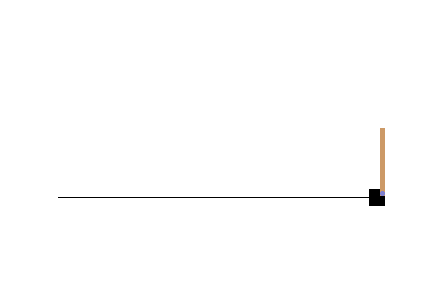
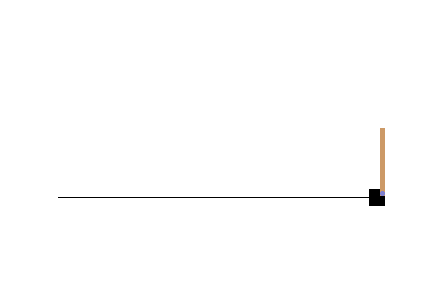
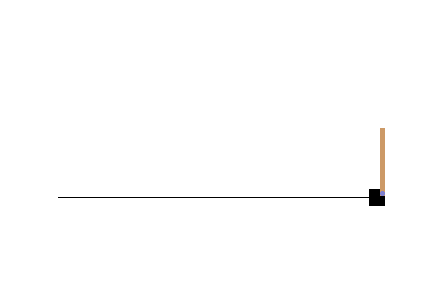
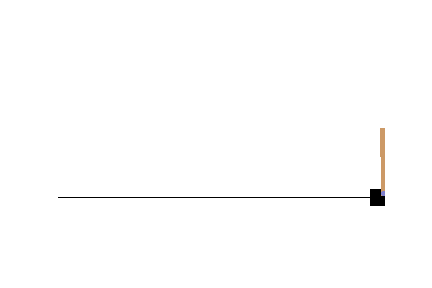
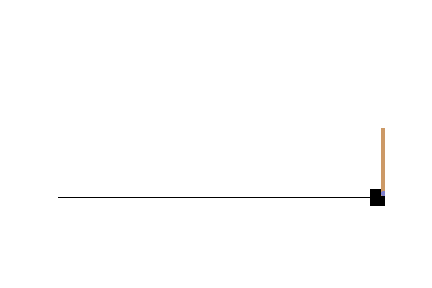
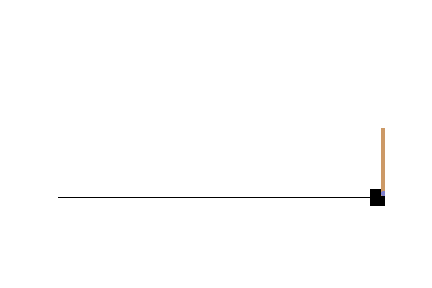
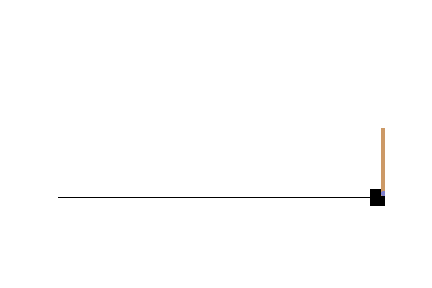
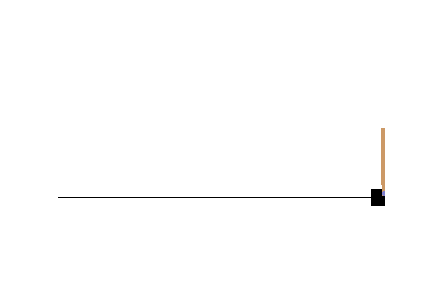
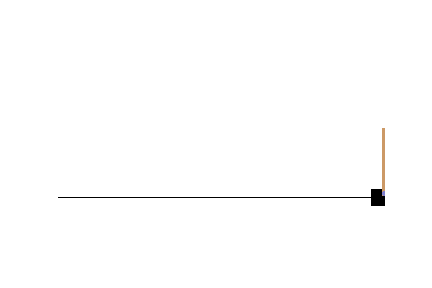
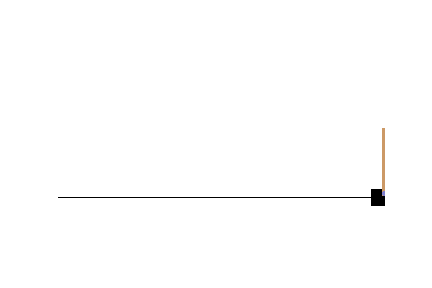

In [6]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = agent.control([obs])
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)